# Introduction

This notebok summarizes the research for the **Smart Search in a Clinical Bot** project. <br>

## Problem description

The purpose of the project is to enable a smart NLP-based search in a clinical bot.
<br>
In the current setting, a patient uses Antidote's service in two phases. The first phase is the self-intake through bot. The bot asks several questions regarding patients' demographics and health status. The questions in the bot are hard-coded (closed set of questions) and are based on general clinical protocols. In the second phase, the patient interacts with a doctor through a video call. In the end of the visit, the doctor fills in the relevant information in the EMR (Electronic Medical Record). 
<br>
In the bot – when a patient enters the “chief complaint” (in other words the reason for arrival), they need to choose from a closed set of symptoms. On many occasions the list does not match the natural language of the patient (E.g. symptom “abdominal pain” uses a more clinical terminology than “stomach pain”). Patients are not aware that they need to type specific name of a symptom, and they prefer writing a free text sentence like “my stomach hurts”. We do not support this kind of sentence, so we suggest them to choose “abdominal pain” instead. Many times, the sentences that patients type do not correlate with existing exact words in the symptoms database, which causes patients’ frustration and abandonment of the service.

## Dataset description

The data includes free search phrases that are logged during bot’s operation (total of ~20K different searches) and actual chief complaints that patients chose.

## Project goal

The main goal of the project is to enable chief complaint symptom entity extraction from the free text that patients type in, and presentation of the relevant set of chief complaints to the patient to choose from.

## Proposed solution

The initial bot mechanism before the current project was based on a free text symbol matching. We propose a different approach which is based on the following components of the symptom prediction process: <br>
- Fuzzy similarity by Levenshtein distance
- Semantic similarity produced by transformer embeddingings
- Symptom popularity factor
- Ranking by top-5 symptoms / symptom categories

# Data Preprocessing

## Installs & Imports

### Installs

In [ ]:
pip install pathlib2 

In [ ]:
pip install glom

In [ ]:
pip install bioinfokit

In [ ]:
pip install pandas_profiling

In [ ]:
pip install addcopyfighandler

In [ ]:
pip install openpyxl  

In [ ]:
pip install swifter

In [ ]:
pip install datasets

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib2 as pl2
import glob
from multiprocessing import Pool 
import os
from tqdm.auto import tqdm
from pandas.io.json import json_normalize
from glom import glom
import json
import ast
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.cm import get_cmap
import addcopyfighandler
import collections
from IPython.display import HTML
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import itertools
from ast import literal_eval
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from nltk.util import ngrams
from langdetect import detect
from sentence_transformers import SentenceTransformer, util
from sklearn.manifold import TSNE
from bioinfokit.visuz import cluster
from sklearn.cluster import DBSCAN
import torch
import operator
from zipfile import ZipFile

In [127]:
tqdm.pandas()

## Handle data from daiagnosis table

### Load diagnosis table data from zip / csv files

In [12]:
%%time
diag_files = ZipFile('bot_prod\diagnosis_15_5_2022.zip').namelist()
df_from_each_file = (pd.read_json(ZipFile('bot_prod\diagnosis_15_5_2022.zip').open(f), lines=True) for f in tqdm(diag_files))
df_diagnosis_all = pd.concat(df_from_each_file, ignore_index=True)
df_diagnosis_all.info()

  0%|          | 0/29 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870543 entries, 0 to 1870542
Data columns (total 19 columns):
 #   Column              Dtype              
---  ------              -----              
 0   event_type          object             
 1   processing_time     datetime64[ns, UTC]
 2   source_time         datetime64[ns, UTC]
 3   user_id             object             
 4   user_name           object             
 5   session_id          object             
 6   uvn                 object             
 7   origin              object             
 8   weight              float64            
 9   height              float64            
 10  measure_system      object             
 11  age                 int64              
 12  gender              object             
 13  language            object             
 14  evidences           object             
 15  conditions          object             
 16  next_question_id    object             
 17  next_question_text  object 

### Filter out all the NON-English records because it was decided to focus only on the English sessions

In [13]:
df_diagnosis_all = df_diagnosis_all[df_diagnosis_all['language']=='english']
df_diagnosis_all.shape

(497614, 19)

### Flatten evidences column fields from the json format. 

In [15]:
%%time
exploded_diagnosis = df_diagnosis_all.explode("evidences").reset_index()
unpacked_diagnosis = pd.json_normalize(exploded_diagnosis["evidences"])
flattened_diagnosis = pd.concat([exploded_diagnosis, unpacked_diagnosis], axis=1)

display(flattened_diagnosis.head(2)), display(flattened_diagnosis.tail(2))
flattened_diagnosis.info()

index      event_type                  processing_time  \
0      0  DiagnosisEvent 2022-05-09 14:32:54.882496+00:00   
1      0  DiagnosisEvent 2022-05-09 14:32:54.882496+00:00   

                       source_time user_id  user_name  \
0 2022-05-09 14:32:54.882498+00:00   49319  AnnaBelle   
1 2022-05-09 14:32:54.882498+00:00   49319  AnnaBelle   

                             session_id    uvn   origin  weight  ...  gender  \
0  8d9c2c7c-f4ae-4da4-a8dd-ae6885f3546b  49319  Default     0.0  ...  FEMALE   
1  8d9c2c7c-f4ae-4da4-a8dd-ae6885f3546b  49319  Default     0.0  ...  FEMALE   

  language                                          evidences conditions  \
0  english  {'choice_id': 'Present', 'id': 'covid_recovere...         []   
1  english  {'choice_id': 'Present', 'id': 'covid_vaccinat...         []   

             next_question_id                    next_question_text  \
0  foreign_body_in_the_throat  Have you swallowed a foreign object?   
1  foreign_body_in_the_throat  Have you swallowed a foreign object?   

  should_stop choice_id                id      source  
0       False   Present   covid_recovered  Predefined  
1       False   Present  covid_vaccinated  Predefined  

[2 rows x 23 columns]

index      event_type                  processing_time  \
8665998  1870542  DiagnosisEvent 2021-10-20 20:23:06.533022+00:00   
8665999  1870542  DiagnosisEvent 2021-10-20 20:23:06.533022+00:00   

                             source_time user_id user_name  \
8665998 2021-10-20 20:23:06.533029+00:00   11573    Alyssa   
8665999 2021-10-20 20:23:06.533029+00:00   11573    Alyssa   

                                   session_id    uvn   origin  weight  ...  \
8665998  a195a482-c291-465e-aa35-143f16031167  11573  Default   235.0  ...   
8665999  a195a482-c291-465e-aa35-143f16031167  11573  Default   235.0  ...   

         gender language                                          evidences  \
8665998  FEMALE  english  {'choice_id': 'Absent', 'id': 'joint_pain', 's...   
8665999  FEMALE  english  {'choice_id': 'Absent', 'id': 'gluten_intolera...   

                                                conditions next_question_id  \
8665998  [{'common_name': 'Acute stress reaction', 'pro...         jaundice   
8665999  [{'common_name': 'Acute stress reaction', 'pro...         jaundice   

                             next_question_text should_stop choice_id  \
8665998  Does your skin seem abnormally yellow?        True    Absent   
8665999  Does your skin seem abnormally yellow?        True    Absent   

                         id   source  
8665998          joint_pain  Dynamic  
8665999  gluten_intolerance  Dynamic  

[2 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666000 entries, 0 to 8665999
Data columns (total 23 columns):
 #   Column              Dtype              
---  ------              -----              
 0   index               int64              
 1   event_type          object             
 2   processing_time     datetime64[ns, UTC]
 3   source_time         datetime64[ns, UTC]
 4   user_id             object             
 5   user_name           object             
 6   session_id          object             
 7   uvn                 object             
 8   origin              object             
 9   weight              float64            
 10  height              float64            
 11  measure_system      object             
 12  age                 int64              
 13  gender              object             
 14  language            object             
 15  evidences           object             
 16  conditions          object             
 17  next_question_id    object 

### Keep only records related to 'Initial' symptoms (from testual search) 

In [220]:
flattened_diagnosis = flattened_diagnosis[flattened_diagnosis.source =='Initial']
flattened_diagnosis = flattened_diagnosis.drop_duplicates(subset=['session_id','id'])
flattened_diagnosis.shape

(87532, 23)

### Get sessions with Diabetes

In [16]:
diabetes_df = flattened_diagnosis[(flattened_diagnosis.id == 'diabetes') & (flattened_diagnosis.choice_id == 'Present') & (flattened_diagnosis.source == 'Predefined')]

In [17]:
diabetes_df.session_id.nunique()

1157

### Create selected symptoms dictionary

In [20]:
%%time
from collections import Counter
selected_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial'].drop_duplicates(["session_id", "id"]).id
selected_symptoms_dict = selected_symptoms.value_counts(normalize=True).round(decimals = 3).to_dict()
Counter(selected_symptoms_dict).most_common(10)

Wall time: 1.92 s


[('sore_throat', 0.037),
 ('nausea', 0.033),
 ('headache', 0.033),
 ('pounding_headache', 0.028),
 ('vomiting', 0.028),
 ('cough', 0.026),
 ('fatigue', 0.026),
 ('diarrhea', 0.026),
 ('fever', 0.025),
 ('body_aches', 0.022)]

### Create popularity table

In [77]:
df_symptoms_popularity = flattened_diagnosis[flattened_diagnosis['source']=='Initial'].drop_duplicates(["session_id", "id"])[['session_id','gender','age','id']]
df_symptoms_popularity['diabetes'] = df_symptoms_popularity.session_id.isin(diabetes_df.session_id.unique())
df_symptoms_popularity.shape

(87532, 5)

In [78]:
df_symptoms_popularity[df_symptoms_popularity.id == 'toothache'].head()

session_id  gender  age         id  diabetes
2433   23969602-f9fd-4b80-a83c-4a89fb114c5c    MALE   20  toothache     False
4645   60612f4d-5b35-4b1d-88ee-c3147bf0bb38  FEMALE   46  toothache     False
11265  46b614ee-8a66-4b39-9695-706d18dda2a8    MALE   31  toothache     False
50253  6a2bcac8-d52f-44c6-8270-9fb5076cd503    MALE    8  toothache     False
87014  f2dacbba-7757-4c19-9c01-63cd5dcdb632  FEMALE   48  toothache      True

## Handle data from search table

### Load search search data from search_english.csv and keep only english searches

In [22]:
df_search = pd.read_csv("bot_prod/search_prod.15.05.22.csv",index_col=0, header=0)

df_search = df_search[df_search['lang']=='english']

df_search.head()

event_type                   processing_time  \
0  SearchEvent  2022-05-02 05:22:38.575114+00:00   
1  SearchEvent  2022-05-02 05:22:43.040158+00:00   
2  SearchEvent  2022-05-02 05:22:44.308645+00:00   
3  SearchEvent  2022-05-02 05:22:51.577448+00:00   
4  SearchEvent  2022-05-02 05:22:53.077465+00:00   

                        source_time       phrase     lang  user_id  \
0  2022-05-02 05:22:38.575116+00:00         Thro  english    47754   
1  2022-05-02 05:22:43.040160+00:00     Throwing  english    47754   
2  2022-05-02 05:22:44.308647+00:00  Throwing up  english    47754   
3  2022-05-02 05:22:51.577450+00:00          The  english    47754   
4  2022-05-02 05:22:53.077467+00:00        Throw  english    47754   

                                    search_responses  \
0  [{'id': 'sore_throat', 'label': 'Sore throat',...   
1                                                 []   
2                                                 []   
3  [{'id': 'mass_or_swelling_around_the_anus', 'l...   
4                                                 []   

                             session_id  
0  ee6b83cf-723d-4e6c-b206-e8833e0dc2d4  
1  ee6b83cf-723d-4e6c-b206-e8833e0dc2d4  
2  ee6b83cf-723d-4e6c-b206-e8833e0dc2d4  
3  ee6b83cf-723d-4e6c-b206-e8833e0dc2d4  
4  ee6b83cf-723d-4e6c-b206-e8833e0dc2d4

### Filter searches with missing search phrase

In [27]:
df_search = df_search[~df_search.phrase.isna()]
df_search.shape

(286541, 8)

### Remove stop words / convert to lower case and tokenize phrases

In [28]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
stop = set(stopwords.words('english'))

In [30]:
def lemmatize_tokenize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    stop = set(stopwords.words('english'))
    return [lemmatizer.lemmatize(word, pos='v') for word in list(set(tokenizer.tokenize(text.lower()))) if word not in stop]

In [32]:
%%time
df_search['phrase'] = df_search['phrase'].str.lower()
df_search['phrase_tokens']=df_search['phrase'].progress_apply(lambda text : lemmatize_tokenize_text(text) if isinstance(text, str) else np.nan)
df_search['phrase_tokens'].head()

  0%|          | 0/286541 [00:00<?, ?it/s]

Wall time: 51.6 s


0     [thro]
1    [throw]
2    [throw]
3         []
4    [throw]
Name: phrase_tokens, dtype: object

### Get sessions with only one selected chief symptom
Why?  Because when session has more than one selected symptom - we struggle to map the textaul search record to to the relevant selected symptom of the same search due to unsopporing DB architechture.  therefore we decided to work with session having a single selected sessions. this we know for sure that the textual searches related to this specific symptom.

In [33]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial'].drop_duplicates(["session_id", "id"])
sessions_with_single_symptome_selected = df_initial_symptoms.groupby('session_id').filter(lambda x: len(x)==1).session_id.to_list()
single_symptom_serches = df_search[df_search.session_id.isin(sessions_with_single_symptome_selected)]

Wall time: 3.46 s


### Filter substring tokens from the searches because
Why? Since our production data is based on symbol mathcing mechanism we want to keep only unique / significant searches per session <br> without having same substring search in multiple records because it has no value for and adds noise to our data.  

In [35]:
def try_len(lane):
    try:
        return len(lane)
    except TypeError:
        return 0

def remove_substrings(df_, drop_empty=True):
    if drop_empty:
        df_ = df_[df_["len"] > 0]
    
    candidates = list()
    candid_id = list()
    
    for i, lane in enumerate(df_["phrase"]):
        for cand in candidates:
            if str(lane) in cand:
                break
        else:
            candidates.append(str(lane))
            candid_id.append(i)
    return df_.iloc[candid_id]

In [36]:
%%time

single_symptom_serches["len"] = single_symptom_serches["phrase"].apply(try_len)
single_symptom_serches.sort_values(by="len", ascending=False, inplace=True)

print (len(single_symptom_serches))

single_symptom_serches = single_symptom_serches.groupby("session_id", group_keys=False).progress_apply(remove_substrings).drop(columns=["len"])

print (len(single_symptom_serches))
single_symptom_serches.head()

67846


  0%|          | 0/12492 [00:00<?, ?it/s]

25181
Wall time: 9.81 s


event_type                   processing_time  \
173903  SearchEvent  2021-09-24 23:17:01.497331+00:00   
192452  SearchEvent  2021-09-24 23:17:02.829479+00:00   
173905  SearchEvent  2021-09-24 23:19:21.000152+00:00   
173904  SearchEvent  2021-09-24 23:19:18.308556+00:00   
489519  SearchEvent  2022-01-23 03:11:18.560578+00:00   

                             source_time    phrase     lang  user_id  \
173903  2021-09-24 23:17:01.497343+00:00  numbnedd  english  1348776   
192452  2021-09-24 23:17:02.829489+00:00  numbness  english  1348776   
173905  2021-09-24 23:19:21.000165+00:00    numbnn  english  1348776   
173904  2021-09-24 23:19:18.308577+00:00      numm  english  1348776   
489519  2022-01-23 03:11:18.560580+00:00  headache  english    23667   

                                         search_responses  \
173903                                                 []   
192452  [{'id': 'face_numbness', 'label': 'Face numbne...   
173905                                                 []   
173904                                                 []   
489519  [{'id': 'generalized_headache', 'label': 'Gene...   

                                  session_id phrase_tokens  
173903  00010a81-042f-468f-8cd0-f78ff11d443d    [numbnedd]  
192452  00010a81-042f-468f-8cd0-f78ff11d443d    [numbness]  
173905  00010a81-042f-468f-8cd0-f78ff11d443d      [numbnn]  
173904  00010a81-042f-468f-8cd0-f78ff11d443d        [numm]  
489519  000832de-692d-43a7-8bdb-60492f132108    [headache]

### Filter by tokens up to 3 words. Take up to 5 longest searches per session with 3 or more chars. Filter non english phrases.
Why? Becuase we want to test our phuzzy based mechanism on simple searches (short phrases). <br>
Phrases with less than 3 chars mostly have no meaning <br>
We try to take the 5 longest searches from the remaining searches per session because we want to focus on the searches that are close to to onse that yielded the selected symptom<br>
isascii  is used for removing searches having non acii charachtes  - those are mostly seacrhes in hebrew or arabic that were mistakenly tagges as English sessions


In [37]:
%%time
df_search_short_phrases = single_symptom_serches[(single_symptom_serches.phrase_tokens.str.len() < 4) & (single_symptom_serches.phrase_tokens.str.len() > 0) & (single_symptom_serches.phrase.str.len() > 2)]
df_search_short_phrases = df_search_short_phrases[df_search_short_phrases.phrase.apply(lambda x: x.isascii())]
df_search_short_phrases = df_search_short_phrases.sort_values(['phrase_tokens'],key=lambda x: x.str.len(), ascending=False).groupby('session_id').head(5)
df_search_short_phrases.head(3)

Wall time: 78.9 ms


event_type                   processing_time  \
108154  SearchEvent  2022-03-08 13:57:58.187563+00:00   
175124  SearchEvent  2021-09-26 21:17:41.820703+00:00   
2733    SearchEvent  2022-04-28 15:38:03.778381+00:00   

                             source_time  \
108154  2022-03-08 13:57:58.187565+00:00   
175124  2021-09-26 21:17:41.820704+00:00   
2733    2022-04-28 15:38:03.778388+00:00   

                                            phrase     lang  user_id  \
108154  in november i had it and had bad headaches  english    34486   
175124                         sprained left ankle  english  1797782   
2733                     swelling of face and eyes  english    46962   

       search_responses                            session_id  \
108154               []  38dbaadd-3c39-4f85-8b0b-65c15a203aab   
175124               []  57208934-9e9c-4137-b366-148b1afe1bc3   
2733                 []  d1f4c3d5-abd2-46b8-a94c-8767265c0352   

                     phrase_tokens  
108154  [bad, headaches, november]  
175124      [leave, sprain, ankle]  
2733            [swell, eye, face]

## Merge searches with diagnosis data 

### Merge searches with diagnosis
Merges df_search_short_phrases with flattened_diagnosis df by session_id <br>
This way we can have in one dataframe both diagnosis (what important is the selected symptom in 'id' field) and the search data.

In [129]:
%%time
merged_symptoms_all_scores_no_duplicates = pd.merge(df_search_short_phrases, flattened_diagnosis, on='session_id')
merged_symptoms_all_scores_no_duplicates = merged_symptoms_all_scores_no_duplicates[merged_symptoms_all_scores_no_duplicates.source == 'Initial']
merged_symptoms_all_scores_no_duplicates.shape

Wall time: 47.9 s


(313339, 36)

### Drop all duplicates  and remove nulls
By keeping only unique searches pers session and selected symptom

In [130]:
%%time
merged_symptoms_all_scores_no_duplicates = merged_symptoms_all_scores_no_duplicates.drop_duplicates(subset=['session_id','id','phrase'])
merged_symptoms_all_scores_no_duplicates.shape

Wall time: 376 ms


(22244, 36)

### Drop abandoned searches from session
Why?  Abandoned search is a search that didn't yield a selected symptom.
Since we have sessions with only one selected symptom, there are sessions having  searches after the single symptom was selected. Those are noise searches that we want to filter. We can use the 'search_responses' field which represents the suggestions shown by the bot to the patient according to his enetred text search. We can assume that once the patient sees the specific symptom he is looking to select among the suggested symptoms, he will selected that specific symptom. Therefore, later searches are meaningless for the session having a single selected symptom. So, we filter the abandoned seatches by sorting the searches in chronologically increasing order and iterating from the last search. We iterate till we hit a search having the selected symptom in one of the suggested symptoms by the symbol mathcing mechanism -  hence, this search is the one in which patient selected the desired symptom. 
Therefore, we can keep this search record and all the searches that occured earlier, while removing the later searches - because they are the abandoned ones.

In [132]:
filtered_abandones_searches = merged_symptoms_all_scores_no_duplicates.sort_values(['session_id','processing_time_x'], ascending = False)

mask_abandoned = merged_symptoms_all_scores_no_duplicates.apply(lambda x:("'id': '{}'".format(x["id"]) in x["search_responses"]), axis=1)
merged_symptoms_all_scores_no_duplicates = merged_symptoms_all_scores_no_duplicates[mask_abandoned.groupby(merged_symptoms_all_scores_no_duplicates['session_id']).cumsum() > 0]

## Load Symptoms Keywords

In [38]:
%%time
import itertools
df_keywords = pd.read_excel("bot_prod/keywords.xlsx")
df_keywords.keywords = df_keywords.keywords.apply(lambda x: x.lower().split(","))
df_keywords.head()

Wall time: 310 ms


symptom_id  \
0            abdominal_distention   
1    abdominal_pain_with_movement   
2         abnormal_appearing_skin   
3       abnormal_breathing_sounds   
4  abnormal_involuntary_movements   

                                            keywords  
0  [abdominal, abdominal_muscle, ab, dilatation, ...  
1  [abdominal, abdominal_muscle, ab, pain, hurtin...  
2  [abnormal, unnatural, appearance, appearing, s...  
3  [abnormal, unnatural, breathing, external_resp...  
4  [abnormal, unnatural, involuntary, nonvoluntar...

### Create keywords_set hash set

In [136]:
%%time
#prepare keywords_set with unique keywords
words = df_keywords['keywords']
words = list(itertools.chain(words))
keywords_set = set()

for word in words:
    keywords_set.update(word)
    
if ('' in keywords_set):
    keywords_set.remove('')
    
list(keywords_set)[:10]

Wall time: 30.9 ms


['ass',
 'concussion',
 'hand',
 'forearm',
 'fatigue',
 'ocular',
 'fatique',
 'bladder',
 'wearing',
 'night']

### Create keywords_to_symptoms dictionary

In [40]:
%%time

# build keys_to_symptoms dictionary
keywords_to_symptoms = {} 

for index_label, row_series in tqdm(df_keywords.iterrows()):
    for keyword in row_series['keywords']:
        list_of_symptoms = keywords_to_symptoms.setdefault(keyword, [])
        if row_series['symptom_id'] not in list_of_symptoms:
            keywords_to_symptoms[keyword].append(row_series['symptom_id'])
            

list(keywords_to_symptoms.items())[:2]

0it [00:00, ?it/s]

Wall time: 89.3 ms


[('abdominal',
  ['abdominal_distention',
   'abdominal_pain_with_movement',
   'burning_abdominal_pain',
   'general_abdominal_pain',
   'increased_abdominal_size',
   'lower_abdominal_pain',
   'right_upper_abdominal_pain',
   'sharp_abdominal_pain',
   'soft_lump_in_inguinal_region_enlarging_during_increase_in_abdominal_pressure',
   'upper_abdominal_pain']),
 ('abdominal_muscle',
  ['abdominal_distention',
   'abdominal_pain_with_movement',
   'burning_abdominal_pain',
   'general_abdominal_pain',
   'increased_abdominal_size',
   'lower_abdominal_pain',
   'right_upper_abdominal_pain',
   'sharp_abdominal_pain',
   'soft_lump_in_inguinal_region_enlarging_during_increase_in_abdominal_pressure',
   'upper_abdominal_pain'])]

### Create symptom_tokens_to_symptoms dictionary and symptoms_tokens_set

In [41]:
from gensim.parsing.preprocessing import STOPWORDS

def remove_stop_words(text_tokens):
    return [word for word in text_tokens if not word in STOPWORDS]

df_keywords['symptom_tokens'] = df_keywords.progress_apply(lambda x: remove_stop_words(x.symptom_id.split('_')), axis=1)
df_keywords

  0%|          | 0/886 [00:00<?, ?it/s]

symptom_id  \
0                                 abdominal_distention   
1                         abdominal_pain_with_movement   
2                              abnormal_appearing_skin   
3                            abnormal_breathing_sounds   
4                       abnormal_involuntary_movements   
..                                                 ...   
881                 yellow_or_green_discharge_from_ear   
882                                      yellowed_skin   
883            yellowed_skin_after_a_physical_exertion   
884     yellowed_skin_after_a_time_of_increased_stress   
885  yellowed_skin_while_suffering_from_an_infectio...   

                                              keywords  \
0    [abdominal, abdominal_muscle, ab, dilatation, ...   
1    [abdominal, abdominal_muscle, ab, pain, hurtin...   
2    [abnormal, unnatural, appearance, appearing, s...   
3    [abnormal, unnatural, breathing, external_resp...   
4    [abnormal, unnatural, involuntary, nonvoluntar...   
..                                                 ...   
881  [yellow, yellowness, green, greenness, viridit...   
882                    [yellow, skin, tegument, cutis]   
883  [yellow, skin, tegument, cutis, physical, effo...   
884  [yellow, skin, tegument, cutis, time, clip, in...   
885  [yellow, skin, tegument, cutis, agony, sufferi...   

                                       symptom_tokens  
0                             [abdominal, distention]  
1                         [abdominal, pain, movement]  
2                         [abnormal, appearing, skin]  
3                       [abnormal, breathing, sounds]  
4                  [abnormal, involuntary, movements]  
..                                                ...  
881                   [yellow, green, discharge, ear]  
882                                  [yellowed, skin]  
883              [yellowed, skin, physical, exertion]  
884         [yellowed, skin, time, increased, stress]  
885  [yellowed, skin, suffering, infectious, disease]  

[886 rows x 3 columns]

In [43]:
%%time
symptom_tokens_to_symptoms = {} 

for index_label, row_series in tqdm(df_keywords.iterrows()):
    for symptom_token in row_series['symptom_tokens']:
        list_of_symptoms = symptom_tokens_to_symptoms.setdefault(symptom_token, [])
        if row_series['symptom_id'] not in list_of_symptoms:
            symptom_tokens_to_symptoms[symptom_token].append(row_series['symptom_id'])
            
flat_list_symptoms_tokens = [item for sublist in df_keywords['symptom_tokens'].to_list() for item in sublist]
symptoms_tokens_set =  set(flat_list_symptoms_tokens)

0it [00:00, ?it/s]

Wall time: 60.4 ms


## Load Symptoms mapping to groups (categories)
Load all possible symptoms and their relevant categories 
Pay attention that there are symptoms related to more than one symptom category

In [44]:
%%time
df_symptom_mappings = pd.read_excel("bot_prod/symptoms_mapping.xlsx")
df_symptom_mappings.symptom_group = df_symptom_mappings.symptom_group.apply(lambda x: x.lower().split(" or "))
df_symptom_mappings.symptom_group = df_symptom_mappings.symptom_group.apply(lambda x: [group.strip() for group in x])
df_symptom_mappings.head()

Wall time: 67.9 ms


symptom_id  \
0                               abdominal_distention   
1                       abdominal_pain_with_movement   
2  belly_pain_spreading_to_the_left_shoulder_or_s...   
3    belly_pain_spreading_to_the_right_shoulder_area   
4                                           bloating   

                                            keywords           symptom_group  
0  abdominal,abdominal_muscle,ab,dilatation,diste...  [abdominal discomfort]  
1  abdominal,abdominal_muscle,ab,pain,hurting,mot...  [abdominal discomfort]  
2  abdomen,venter,stomach,belly,pain,hurting,spre...  [abdominal discomfort]  
3  abdomen,venter,stomach,belly,pain,hurting,spre...  [abdominal discomfort]  
4  bloat,lower_berth,lower,abdomen,venter,stomach...  [abdominal discomfort]

In [47]:
groups_to_symptoms = {} 

for index_label, row_series in tqdm(df_symptom_mappings.iterrows()):
    for group in row_series['symptom_group']:
        list_of_symptoms = groups_to_symptoms.setdefault(group, [])
        if row_series['symptom_id'] not in list_of_symptoms:
            groups_to_symptoms[group].append(row_series['symptom_id'])

0it [00:00, ?it/s]

In [48]:
symptoms_to_groups = dict(zip(df_symptom_mappings.symptom_id, df_symptom_mappings.symptom_group))

In [49]:
list(symptoms_to_groups.items())[:5]

[('abdominal_distention', ['abdominal discomfort']),
 ('abdominal_pain_with_movement', ['abdominal discomfort']),
 ('belly_pain_spreading_to_the_left_shoulder_or_shoulder_blade',
  ['abdominal discomfort']),
 ('belly_pain_spreading_to_the_right_shoulder_area', ['abdominal discomfort']),
 ('bloating', ['abdominal discomfort'])]

# EDA

### Symptoms Popularity

In [79]:
text_selected_symptoms = df_symptoms_popularity.id.nunique()
all_possible_symptoms = df_keywords.index.nunique()
print(f'Number of unique selected symptoms via textual search =  {text_selected_symptoms}')
print(f'Number of all possible symptoms from the keywords excel file =  {all_possible_symptoms}')


Number of unique selected symptoms via textual search =  848
Number of all possible symptoms from the keywords excel file =  886


#### Popularity function

In [85]:
def get_symptom_popularity(gender = None, min_age = None, max_age = None, diabetes = None):
    symptoms_popularity = df_symptoms_popularity
    if (gender is not None):
        symptoms_popularity = symptoms_popularity[symptoms_popularity.gender == gender]
    if (min_age is not None):
        symptoms_popularity = symptoms_popularity[symptoms_popularity.age >= min_age]
    if (max_age is not None):
        symptoms_popularity = symptoms_popularity[symptoms_popularity.age <= max_age]
    if (diabetes is not None):
        symptoms_popularity = symptoms_popularity[symptoms_popularity.diabetes == diabetes]
    selected_symptoms_dict = symptoms_popularity.id.value_counts(normalize=True).to_dict()
    return selected_symptoms_dict

#### Different Symptoms Popularity examples

In [796]:
symptoms_pop = get_symptom_popularity(min_age = 80, max_age = 90)
Counter(symptoms_pop).most_common(4)

[('cough', 0.0625),
 ('fatigue', 0.041666666666666664),
 ('congestion_in_chest', 0.03125),
 ('neck_pain', 0.03125)]

In [802]:
symptoms_pop = get_symptom_popularity()
pd.Series(symptoms_pop).sum()

1.0

In [53]:
symptoms_pop = get_symptom_popularity(gender = 'FEMALE', min_age = None, max_age = None)
Counter(symptoms_pop).most_common(4)

[('headache', 0.049),
 ('cough', 0.039),
 ('sore_throat', 0.035),
 ('nausea', 0.029)]

In [44]:
symptoms_pop = get_symptom_popularity(gender = 'MALE', min_age = None, max_age = None)
Counter(symptoms_pop).most_common(4)

[('sore_throat', 0.04),
 ('headache', 0.034),
 ('diarrhea', 0.032),
 ('vomiting', 0.031)]

In [517]:
symptoms_pop = get_symptom_popularity()
Counter(symptoms_pop).most_common(10)

[('sore_throat', 0.037),
 ('nausea', 0.033),
 ('headache', 0.033),
 ('pounding_headache', 0.028),
 ('vomiting', 0.028),
 ('cough', 0.026),
 ('fatigue', 0.026),
 ('diarrhea', 0.026),
 ('fever', 0.025),
 ('body_aches', 0.022)]

### Show symptoms sources distribution:  Dynamic / Initial / Predefined 

Wall time: 45.7 s


<AxesSubplot:title={'center':'source'}>

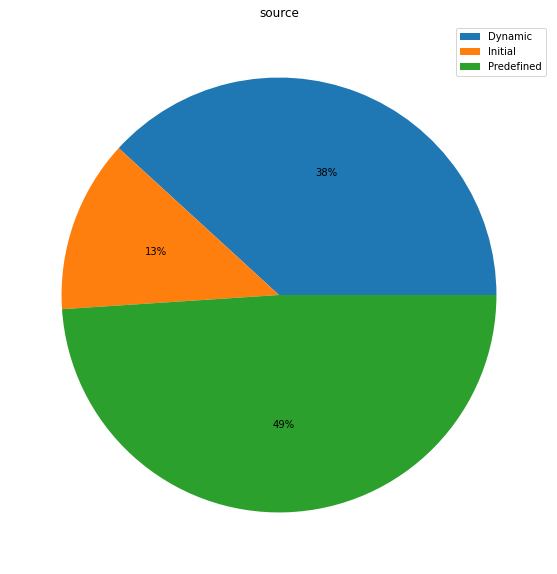

In [64]:
%%time  
merged.source.str.get_dummies().sum().plot.pie(title = 'source',autopct='%1.0f%%',figsize=(10,10), legend=True, label='', labeldistance=None)

### Show symptoms sources distribution by sources and their states

In [66]:
%%time  
outer = merged.groupby('source').size()
inner = merged.groupby(['source', 'choice_id']).size()
inner, outer

Wall time: 3.4 s


(source      choice_id
 Dynamic     Absent       4220425
             Present      1955206
             Unknown       152879
 Initial     Present      2127882
 Predefined  Absent       6603008
             Present      1356310
             Unknown       152596
 dtype: int64,
 source
 Dynamic       6328510
 Initial       2127882
 Predefined    8111914
 dtype: int64)

In [67]:
%%time  
inner_labels = inner.index.get_level_values(1)
# inner_labels
list(inner_labels)
set(inner_labels)

Wall time: 0 ns


{'Absent', 'Present', 'Unknown'}

In [68]:
color_dict =  {'Absent': 'red',  'Unknown': 'yellow', 'Present': 'green'}
# color_dict[inner_labels]
[color_dict[k] for k in list(inner_labels)]

['red', 'green', 'yellow', 'green', 'red', 'green', 'yellow']

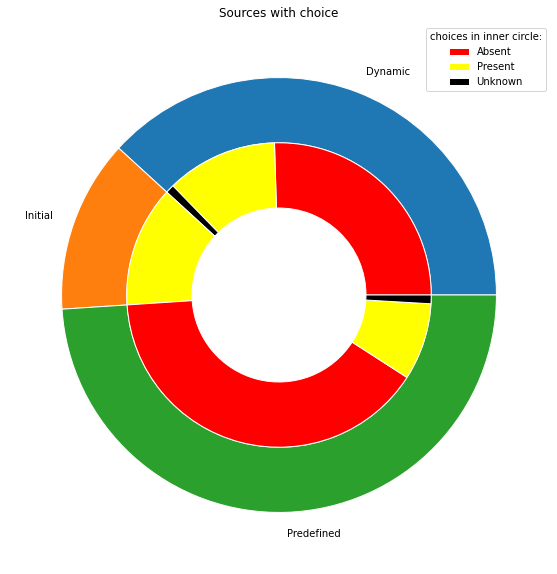

Wall time: 161 ms


In [69]:
%%time  
fig, ax = plt.subplots(figsize=(20,10))
size = 0.3

color_dict =  {'Absent': 'red',  'Unknown': 'black', 'Present': 'yellow'}
inner_colors = [color_dict[k] for k in list(inner_labels)]

ax.pie(outer.values.flatten(), radius=1, 
       labels=outer.index,
       wedgeprops=dict(width=size, edgecolor='w'))

inner_circle, _  = ax.pie(inner.values.flatten(), radius=1-size,  colors=inner_colors,
       labeldistance=None,
       labels = inner_labels,
       wedgeprops=dict(width=size, edgecolor='w'))

inner_legends = [inner_circle[i].get_label() for i,k in enumerate(inner_circle)]

ax.set(aspect="equal", title='Sources with choice')
plt.legend(inner_circle[:len(color_dict)], inner_legends[:len(color_dict)], title = 'choices in inner circle:')
plt.show()

### Sessions per patients (based on search table)

In [71]:
%%time  
# show number of sessions per number of users from search table
from IPython.display import HTML

list_sessions = df_search.groupby(df_search.user_id)['session_id'].nunique()
sessions_counter_patients = collections.Counter(list_sessions)
sorted_by_count = sessions_counter_patients.most_common()
users_sessions_df = pd.DataFrame(data = sorted_by_count, columns=['sessions per patient', 'patients'])
HTML(users_sessions_df.to_html(index=False))

Wall time: 57.5 ms


(1.0, 7.0)

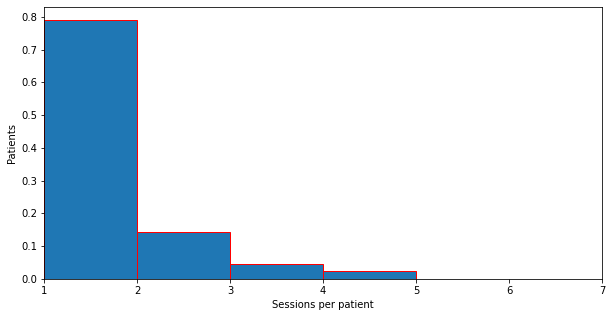

In [72]:
fig, ax = plt.subplots(figsize=(10,5))

bins='auto'
bins=[1,2,3,4,5]
# bins=5
ax.hist(list_sessions,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Patients')
plt.xlabel('Sessions per patient');
plt.xlim(xmin=1, xmax = 7)

In [73]:
sessions_patients_df = pd.DataFrame(data = sessions_counter_patients.most_common(), columns=['Sessions', 'Patients'])
sessions_repeated_df= sessions_patients_df.loc[sessions_patients_df.index.repeat(sessions_patients_df.Patients)]
sessions_repeated_df.drop('Patients', 1,inplace=True)
sessions_repeated_df.describe()

Sessions
count  12343.000000
mean       1.368792
std        1.005303
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       25.000000

### Searches per session (based on search table)

In [74]:
%%time  
# show number of records by session per number of sessions from search table
from IPython.display import HTML

searches_grouped_by_sessions = df_search.groupby(df_search.session_id).size()
searches_counter_sessions = collections.Counter(searches_grouped_by_sessions)
sorted_by_count = searches_counter_sessions.most_common(10)
seraches_per_session = pd.DataFrame(data = sorted_by_count, columns=['searches per session', 'sessions'])
HTML(seraches_per_session.to_html(index=False))

Wall time: 27.6 ms


Text(0.5, 1.0, 'Searches per session ')

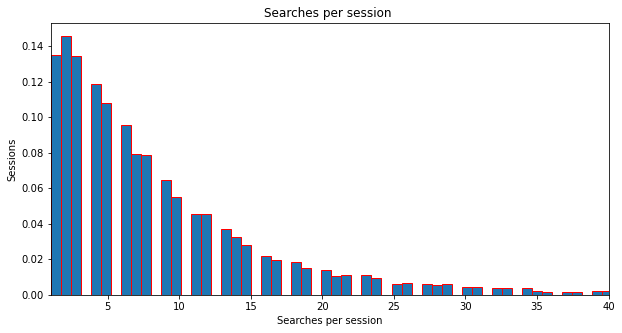

In [75]:
fig, ax = plt.subplots(figsize=(10,5))

bins='auto'
ax.hist(searches_grouped_by_sessions,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Sessions')
plt.xlabel('Searches per session');
plt.xlim(xmin=1, xmax = 40)
plt.title('Searches per session ')

In [76]:
searches_seasssions_df = pd.DataFrame(data = searches_counter_sessions.most_common(), columns=['searches', 'sessions'])
searhces_repeated_df= searches_seasssions_df.loc[searches_seasssions_df.index.repeat(searches_seasssions_df.sessions)]
searhces_repeated_df.drop('sessions', 1,inplace=True)
searhces_repeated_df.describe()

searches
count  16895.000000
mean       9.537319
std       12.331224
min        1.000000
25%        3.000000
50%        6.000000
75%       12.000000
max      240.000000

### Word cloud of selected chied complaints

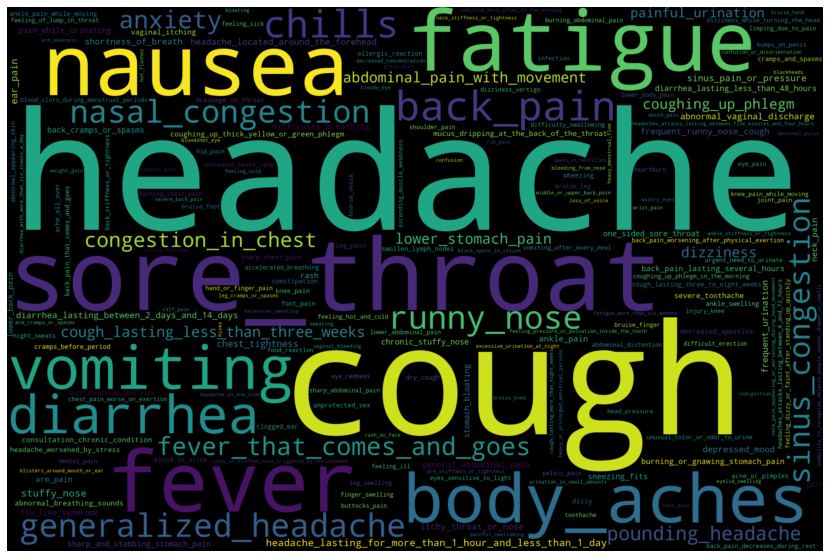

Wall time: 8.8 s


([('headache', 2150),
  ('cough', 1885),
  ('sore_throat', 1595),
  ('nausea', 1151),
  ('fever', 1114),
  ('fatigue', 1112),
  ('body_aches', 1110),
  ('vomiting', 943),
  ('diarrhea', 881),
  ('back_pain', 807)],
 [('suspicious_mole_or_birthmark_on_the_skin', 1),
  ('spotting_or_bleeding_during_pregnancy', 1),
  ('red_and_warm_skin_change_on_eyelid', 1),
  ('regurgitation', 1),
  ('contact_with_allergen', 1),
  ('hives_appearing_after_exposure_to_prolonged_pressure_on_the_skin', 1),
  ('temporary_blindness', 1),
  ('loss_of_feeling_in_tongue', 1),
  ('too_little_hair', 1),
  ('sore_in_nose', 1)])

In [77]:
%%time
#symptoms from diagnosis evidences
from wordcloud import WordCloud
from collections import Counter

# initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial'].id.dropna().tolist()
initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial'].drop_duplicates(["session_id", "id"]).id

word_cloud_counter=Counter(initial_symptoms)
# word_cloud_counter=Counter(flattened_diagnosis.id.dropna().tolist())
wordcloud = WordCloud(width = 3000, height = 2000,collocations=False).generate_from_frequencies(word_cloud_counter)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
word_cloud_counter.most_common(10), word_cloud_counter.most_common()[-10:]

### Demographics: Male with chief complaint

In [78]:
%%time
from collections import Counter

male_initial_symptoms = flattened_diagnosis[(flattened_diagnosis['source']=='Initial') & (flattened_diagnosis['gender']=='MALE')].id.dropna().tolist()
symptom_counter=Counter(male_initial_symptoms)
symptom_counter.most_common(10)

Wall time: 826 ms


[('headache', 11736),
 ('cough', 11584),
 ('sore_throat', 9436),
 ('fever', 7066),
 ('diarrhea', 5899),
 ('body_aches', 5789),
 ('fatigue', 5779),
 ('vomiting', 5428),
 ('nausea', 5137),
 ('back_pain', 4488)]

### Demographics: Female with chief complaint

In [79]:
%%time
from collections import Counter

female_initial_symptoms = flattened_diagnosis[(flattened_diagnosis['source']=='Initial') & (flattened_diagnosis['gender']=='FEMALE')].id.dropna().tolist()
symptom_counter=Counter(female_initial_symptoms)
symptom_counter.most_common(10)

Wall time: 900 ms


[('headache', 16629),
 ('cough', 13173),
 ('sore_throat', 11641),
 ('nausea', 9720),
 ('fatigue', 7905),
 ('body_aches', 7714),
 ('fever', 7320),
 ('vomiting', 7210),
 ('back_pain', 6614),
 ('diarrhea', 5909)]

### Most common chief complaint - headache - demographics

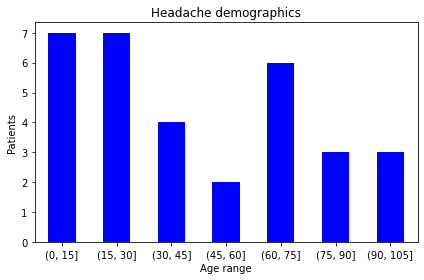

Wall time: 861 ms


In [80]:
%%time
from collections import Counter

headache_initial_symptoms = flattened_diagnosis[(flattened_diagnosis['source']=='Initial') & (flattened_diagnosis['id']=='headache')]
headache_symptoms_grouped_by_age = headache_initial_symptoms.groupby(headache_initial_symptoms.age)['id'].count()

out = pd.cut(headache_symptoms_grouped_by_age, bins=[0,15, 30, 45, 60, 75,90 , 105])
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
plt.ylabel('Patients')
plt.xlabel('Age range');
plt.title('Headache demographics');

# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### Chief complaints per patient

In [81]:
%%time

df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
initial_symptoms_grouped_by_patient = df_initial_symptoms.groupby(df_initial_symptoms.user_id)['id'].nunique()
symptoms_counter_patient = collections.Counter(initial_symptoms_grouped_by_patient)
sorted_by_count = symptoms_counter_patient.most_common()
users_symptoms_df = pd.DataFrame(data = sorted_by_count, columns=['Chief complaints per patient', 'patients'])
HTML(users_symptoms_df.head(10).to_html(index=False))

Wall time: 803 ms


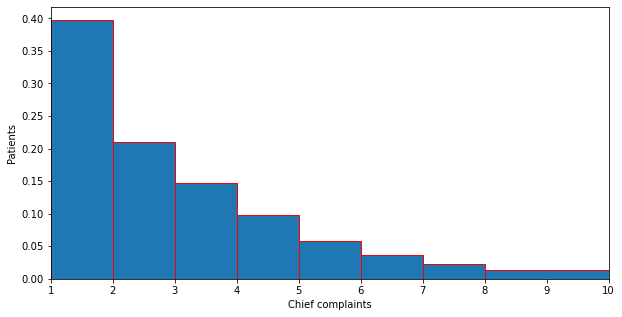

In [82]:
fig, ax = plt.subplots(figsize=(10,5))

# bins='auto'
bins=[1,2,3,4,5,6,7,8,10]
plt.ylabel('Patients')
plt.xlabel('Chief complaints');
plt.xlim(xmin=1, xmax = 10)
ax.hist(initial_symptoms_grouped_by_patient,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)

In [83]:
symptoms_patients_df = pd.DataFrame(data = symptoms_counter_patient.most_common(), columns=['chief complaints', 'patients'])
symptoms_patients_df= symptoms_patients_df.loc[symptoms_patients_df.index.repeat(symptoms_patients_df.patients)]
symptoms_patients_df.drop('patients', 1,inplace=True)
symptoms_patients_df.describe()


chief complaints
count      13195.000000
mean           2.748617
std            2.531223
min            1.000000
25%            1.000000
50%            2.000000
75%            4.000000
max           49.000000

### Сhief complaints per session

In [84]:
%%time

df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
initial_symptoms_grouped_by_session = df_initial_symptoms.groupby(df_search.session_id)['id'].nunique()
symptoms_counter_session = collections.Counter(initial_symptoms_grouped_by_session)
sorted_by_count = symptoms_counter_session.most_common()
users_symptoms_df = pd.DataFrame(data = sorted_by_count, columns=['Chief complaints per session', 'sessions'])
HTML(users_symptoms_df.to_html(index=False))
# sorted_by_count

Wall time: 811 ms


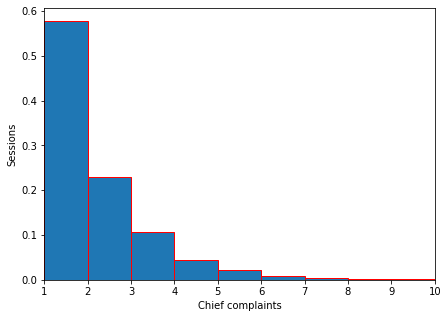

In [85]:
fig, ax = plt.subplots(figsize=(7,5))

# bins='auto'
bins=[1,2,3,4,5,6,7,8,10]
plt.ylabel('Sessions')
plt.xlabel('Chief complaints');
plt.xlim(xmin=1, xmax = 10)
ax.hist(initial_symptoms_grouped_by_session,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)

In [86]:
symptoms_seasssions_df = pd.DataFrame(data = symptoms_counter_session.most_common(), columns=['chief complaints', 'sessions'])
symptoms_seasssions_df= symptoms_seasssions_df.loc[symptoms_seasssions_df.index.repeat(symptoms_seasssions_df.sessions)]
symptoms_seasssions_df.drop('sessions', 1,inplace=True)
symptoms_seasssions_df.describe()

chief complaints
count       7624.000000
mean           1.782922
std            1.258618
min            1.000000
25%            1.000000
50%            1.000000
75%            2.000000
max           16.000000

### Get sessions without repsonses

number of sessions without repsonse:709
Wall time: 124 ms


Text(0.5, 1.0, 'Searches without response')

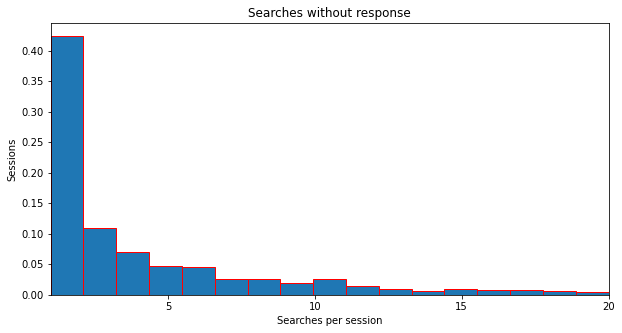

In [87]:
%%time
sessions_with_responses_df = df_search[df_search['search_responses'].map(lambda d: len(d))!= 0]
sessions_with_responses = sessions_with_responses_df.session_id.unique()
sessions_without_response = df_search[~df_search.session_id.isin(sessions_with_responses)]
no_repsonse = sessions_without_response[sessions_without_response.lang == 'english'].session_id.unique()
print(f'number of sessions without repsonse:{len(no_repsonse)}')
# sessions_without_response

searches_grouped_by_sessions = sessions_without_response.groupby(sessions_without_response.session_id).size()
searches_counter_sessions = collections.Counter(searches_grouped_by_sessions)
searches_no_response_count = searches_counter_sessions.most_common()

fig, ax = plt.subplots(figsize=(10,5))

# bins=[1,2,4,8,10,15,20,40,60,80,200]
bins='auto'
ax.hist(searches_grouped_by_sessions,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Sessions')
plt.xlabel('Searches per session');
plt.xlim(xmin=1, xmax = 20)
plt.title('Searches without response')

In [88]:
# df_search
# 709/161133 
# 1527 / 161133

In [89]:
searches_no_repsonse_seasssions_df = pd.DataFrame(data = searches_no_response_count, columns=['searches', 'sessions'])
searches_no_repsonse_seasssions_df= searches_no_repsonse_seasssions_df.loc[searches_no_repsonse_seasssions_df.index.repeat(searches_no_repsonse_seasssions_df.sessions)]
searches_no_repsonse_seasssions_df.drop('sessions', 1,inplace=True)
searches_no_repsonse_seasssions_df.describe()

searches
count  709.000000
mean     5.315938
std      7.623858
min      1.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     77.000000

### Searches till abandon (without selecting chief complaint)

Wall time: 871 ms


[(2, 201),
 (1, 186),
 (3, 178),
 (4, 135),
 (5, 113),
 (7, 82),
 (8, 73),
 (6, 72),
 (9, 48),
 (10, 46)]

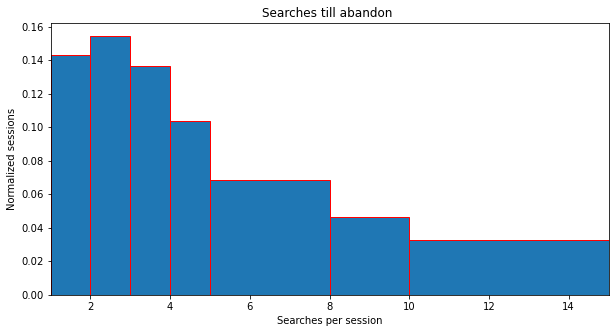

In [96]:
%%time

df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']

missing_from_diagnosis_flattened = df_search[~df_search.session_id.isin(df_initial_symptoms.session_id.unique())]
missing_from_diagnosis = df_search[df_search.session_id.isin(missing_from_diagnosis_flattened.session_id.unique())]
missing_from_diagnosis = missing_from_diagnosis.drop_duplicates(["session_id", "phrase"])

searches_with_chief_complaints = df_search[df_search.session_id.isin(df_initial_symptoms.session_id.unique())]
searches_without_chief_complaints = df_search[~df_search.session_id.isin(searches_with_chief_complaints.session_id.unique())]
searches_without_chief_complaints = searches_without_chief_complaints.drop_duplicates(["session_id", "phrase"])
searches_grouped_by_sessions = searches_without_chief_complaints.groupby(missing_from_diagnosis.session_id).size()



searches_grouped_by_sessions_abandon = missing_from_diagnosis.groupby(missing_from_diagnosis.session_id).size()
searches_counter_sessions = collections.Counter(searches_grouped_by_sessions_abandon)
searches_abandon_count = searches_counter_sessions.most_common()

fig, ax = plt.subplots(figsize=(10,5))

bins=[1,2,3,4,5,8,10,15]
# bins='auto'
ax.hist(searches_grouped_by_sessions,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Normalized sessions')
plt.xlabel('Searches per session');
plt.xlim(xmin=1, xmax = 15)
plt.title('Searches till abandon ')
searches_counter_sessions.most_common(10)

In [97]:
searches_till_abandon_seasssions_df = pd.DataFrame(data = searches_abandon_count, columns=['searches', 'sessions'])
searches_till_abandon_seasssions_df= searches_till_abandon_seasssions_df.loc[searches_till_abandon_seasssions_df.index.repeat(searches_till_abandon_seasssions_df.sessions)]
searches_till_abandon_seasssions_df.drop('sessions', 1,inplace=True)
searches_till_abandon_seasssions_df.describe()

searches
count  1527.000000
mean     10.098887
std      17.769090
min       1.000000
25%       2.000000
50%       5.000000
75%      11.000000
max     231.000000

### Time till abandon

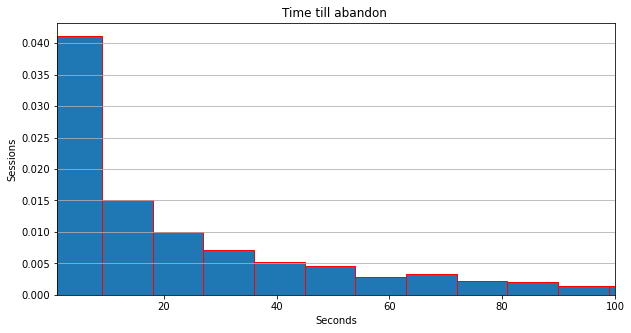

Wall time: 1.6 s


In [98]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
searches_with_chief_complaints = df_search[df_search.session_id.isin(df_initial_symptoms.session_id.unique())]
searches_without_chief_complaints = df_search[~df_search.session_id.isin(searches_with_chief_complaints.session_id.unique())]
searches_without_chief_complaints['time'] = searches_without_chief_complaints['source_time'].apply(pd.to_datetime)
time_diff_abandon = searches_without_chief_complaints.sort_values(['session_id', 'time']).groupby(['session_id'])['time'].agg(lambda x: x.iat[-1] - x.iat[0])


rounded = time_diff_abandon.apply(lambda x: x.round(freq='s').total_seconds())

fig, ax = plt.subplots(figsize=(10,5))

# bins=[1,2,4,8,10,15,20,40,60,80,200]
bins='auto'
ax.hist(rounded,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Sessions')
plt.xlabel('Seconds');
plt.xlim(xmin=1, xmax = 100)
plt.title('Time till abandon ')
plt.grid(axis='y')
plt.show()

In [99]:
#percentage of abndoned sessions
percentage_of_abndoned_sessions = searches_without_chief_complaints.session_id.nunique() / df_search.session_id.nunique()
percentage_of_abndoned_sessions

0.0903817697543652

In [100]:
pd.DataFrame(rounded).describe()

time
count  1527.000000
mean     52.817289
std      98.172809
min       0.000000
25%       3.000000
50%      17.000000
75%      55.000000
max     917.000000

### Searches till selecting last chief complaint (vs. abandon)

Wall time: 807 ms


[(2, 1685),
 (3, 1578),
 (1, 1515),
 (4, 1374),
 (5, 1318),
 (6, 1134),
 (7, 944),
 (8, 870),
 (9, 696),
 (10, 641)]

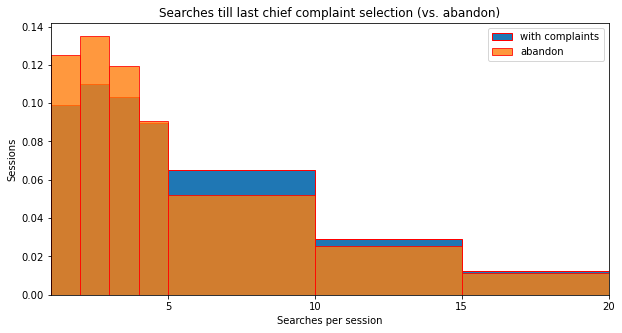

In [101]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
searches_with_chief_complaints = df_search[df_search.session_id.isin(df_initial_symptoms.session_id.unique())]

searches_with_chief_complaints = searches_with_chief_complaints.drop_duplicates(["session_id", "phrase"])

searches_grouped_by_sessions_with_complaint = searches_with_chief_complaints.groupby(searches_with_chief_complaints.session_id).size()
searches_counter_sessions = collections.Counter(searches_grouped_by_sessions_with_complaint)
searches_chief_complaint_count = searches_counter_sessions.most_common()

fig, ax = plt.subplots(figsize=(10,5))

bins=[1,2,3,4,5,10,15,20,50]
# bins='auto'

ax.hist(searches_grouped_by_sessions_with_complaint,bins=bins,edgecolor='red',  density=True, label='with complaints') 
ax.hist(searches_grouped_by_sessions_abandon,bins=bins,edgecolor='red',alpha=0.8, density=True, label = 'abandon') 

ax.locator_params(axis='x', integer=True)
plt.ylabel('Sessions')
plt.xlabel('Searches per session');
plt.xlim(xmin=1, xmax = 20)
plt.legend()
plt.title('Searches till last chief complaint selection (vs. abandon)')
searches_counter_sessions.most_common(10)

In [102]:
searches_with_chief_complaint_seasssions_df = pd.DataFrame(data = searches_chief_complaint_count, columns=['searches', 'sessions'])
searches_with_chief_complaint_seasssions_df= searches_with_chief_complaint_seasssions_df.loc[searches_with_chief_complaint_seasssions_df.index.repeat(searches_with_chief_complaint_seasssions_df.sessions)]
searches_with_chief_complaint_seasssions_df.drop('sessions', 1,inplace=True)
searches_with_chief_complaint_seasssions_df.describe()

searches
count  15368.000000
mean       8.026223
std        8.830399
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max      219.000000

### Time till last chief complaint

Wall time: 6.5 s


Text(0.5, 1.0, 'Time till last chief complaint ')

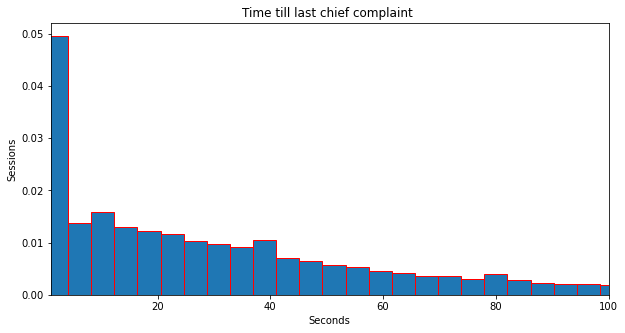

In [103]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
searches_with_chief_complaints = df_search[df_search.session_id.isin(df_initial_symptoms.session_id.unique())]
searches_with_chief_complaints['time'] = searches_with_chief_complaints['source_time'].apply(pd.to_datetime)
time_diff_last_complaint = searches_with_chief_complaints.sort_values(['session_id', 'time']).groupby(['session_id'])['time'].agg(lambda x: x.iat[-1] - x.iat[0])

rounded = time_diff_last_complaint.apply(lambda x: x.round(freq='s').total_seconds())

fig, ax = plt.subplots(figsize=(10,5))

# bins=[1,2,4,8,10,15,20,40,60,80,200]
bins='auto'
ax.hist(rounded,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Sessions')
plt.xlabel('Seconds');
plt.xlim(xmin=1, xmax = 100)
plt.title('Time till last chief complaint ')

In [104]:
pd.DataFrame(rounded).describe()

time
count  15368.000000
mean      48.716229
std       79.124264
min        0.000000
25%        8.000000
50%       27.000000
75%       59.000000
max     2080.000000

### Searches till selecting first and single chief complaint

Wall time: 1.53 s


[(2, 83),
 (3, 72),
 (1, 63),
 (4, 62),
 (5, 52),
 (6, 43),
 (8, 32),
 (7, 32),
 (10, 27),
 (15, 23)]

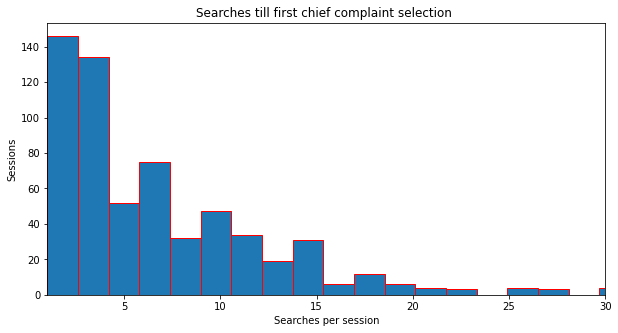

In [105]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
initial_symptoms_grouped_by_session = df_initial_symptoms.groupby(df_search.session_id)
sessions_with_one_chief_complaint = initial_symptoms_grouped_by_session.filter(lambda x: x['id'].count() == 1)

searches_with_one_chief_complaint = df_search[df_search.session_id.isin(sessions_with_one_chief_complaint.session_id.unique())]
searches_with_one_chief_complaint = searches_with_one_chief_complaint.drop_duplicates(["session_id", "phrase"])

searches_grouped_by_sessions = searches_with_one_chief_complaint.groupby(searches_with_one_chief_complaint.session_id).size()
searches_counter_sessions = collections.Counter(searches_grouped_by_sessions)
searches_first_chief_complaint_count = searches_counter_sessions.most_common()

fig, ax = plt.subplots(figsize=(10,5))

# bins=[1,2,4,8,10,15,20,40,60,80,200]
bins='auto'
ax.hist(searches_grouped_by_sessions,bins=bins,edgecolor='red', density=False) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Sessions')
plt.xlabel('Searches per session');
plt.xlim(xmin=1, xmax = 30)
plt.title('Searches till first chief complaint selection ')
searches_counter_sessions.most_common(10)

In [106]:
searches_with_chief_complaint_seasssions_df = pd.DataFrame(data = searches_first_chief_complaint_count, columns=['searches', 'sessions'])
searches_with_chief_complaint_seasssions_df= searches_with_chief_complaint_seasssions_df.loc[searches_with_chief_complaint_seasssions_df.index.repeat(searches_with_chief_complaint_seasssions_df.sessions)]
searches_with_chief_complaint_seasssions_df.drop('sessions', 1,inplace=True)
searches_with_chief_complaint_seasssions_df.describe()

searches
count  617.000000
mean     6.996759
std      6.357580
min      1.000000
25%      3.000000
50%      5.000000
75%     10.000000
max     52.000000

### Time till selecting first and single chief complaint

Wall time: 1.72 s


Text(0.5, 1.0, 'Time till first chief complaint ')

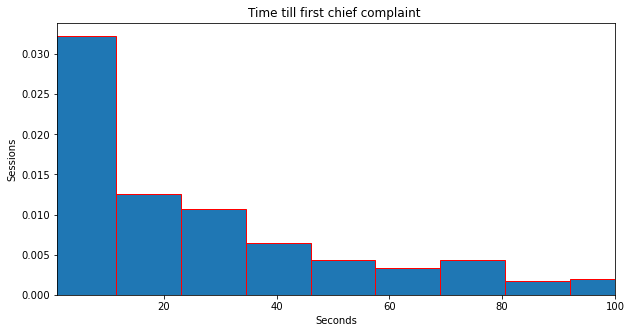

In [107]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
initial_symptoms_grouped_by_session = df_initial_symptoms.groupby(df_search.session_id)
sessions_with_one_chief_complaint = initial_symptoms_grouped_by_session.filter(lambda x: x['id'].count() == 1)
searches_with_one_chief_complaint = df_search[df_search.session_id.isin(sessions_with_one_chief_complaint.session_id.unique())]

searches_with_one_chief_complaint['time'] = searches_with_one_chief_complaint['source_time'].apply(pd.to_datetime)
time_diff_first_complaint = searches_with_one_chief_complaint.sort_values(['session_id', 'time']).groupby(['session_id'])['time'].agg(lambda x: x.iat[-1] - x.iat[0])

rounded = time_diff_first_complaint.apply(lambda x: x.round(freq='s').total_seconds())

fig, ax = plt.subplots(figsize=(10,5))

# bins=[1,2,4,8,10,15,20,40,60,80,200]
bins='auto'
ax.hist(rounded,bins=bins,edgecolor='red', density=True) 
ax.locator_params(axis='x', integer=True)
plt.ylabel('Sessions')
plt.xlabel('Seconds');
plt.xlim(xmin=1, xmax = 100)
plt.title('Time till first chief complaint ')


In [108]:
pd.DataFrame(rounded).describe()

time
count   617.000000
mean     45.137763
std      93.989994
min       0.000000
25%       5.000000
50%      21.000000
75%      54.000000
max    1449.000000

### Get max of chars per session (based on search table)

Wall time: 2.03 s


Text(0.5, 1.0, 'max chars per session')

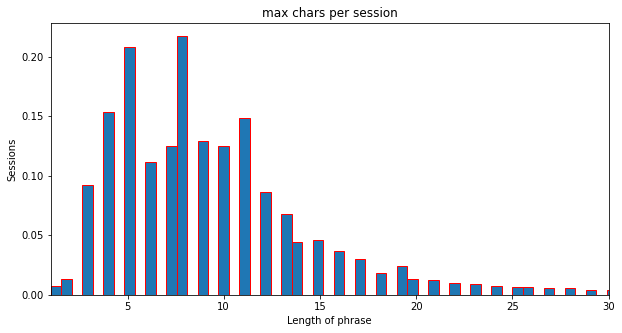

In [109]:
%%time
max_chars_grouped_by_session = df_search.groupby(df_search.session_id)['phrase'].agg(lambda x: x.str.len().max())
max_chars_grouped_by_session.dropna(inplace=True)
# no_responses_grouped_by_session = no_responses_df.groupby(no_responses_df.session_id)['phrase'].nunique()
max_chars_counter_session = collections.Counter(max_chars_grouped_by_session)
max_chars_count = max_chars_counter_session.most_common(10)
# max_chars_count
# max_chars_grouped_by_session.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))

# bins=[10,20,30,40,50,100,240]
# bins='auto'
plt.ylabel('Sessions')
plt.xlabel('Length of phrase');
plt.xlim(xmin=1, xmax = 30)
# ax.hist(max_chars_grouped_by_session,bins=bins,edgecolor='red', density=False) 
ax.hist(max_chars_grouped_by_session,bins=bins,edgecolor='red', density=True) 

ax.locator_params(axis='x', integer=True)
plt.title('max chars per session')

In [110]:
max_chars_sesssions_df = pd.DataFrame(data = max_chars_counter_session.most_common(), columns=['max_chars', 'sessions'])
max_chars_sesssions_df= max_chars_sesssions_df.loc[max_chars_sesssions_df.index.repeat(max_chars_sesssions_df.sessions)]
max_chars_sesssions_df.drop('sessions', 1,inplace=True)
max_chars_sesssions_df.describe()

max_chars
count  16891.000000
mean      11.010775
std       14.275107
min        1.000000
25%        5.000000
50%        8.000000
75%       12.000000
max      481.000000

### Get max words for sessions with chief complaint

Wall time: 3.82 s


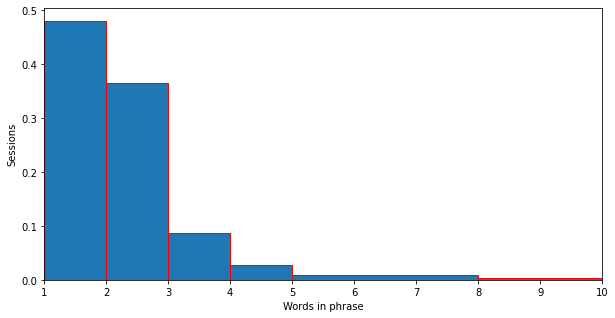

In [111]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
searches_with_chief_complaints = df_search[df_search.session_id.isin(df_initial_symptoms.session_id.unique())]
max_words_grouped_by_session = searches_with_chief_complaints.groupby(searches_with_chief_complaints.session_id)['phrase'].agg(lambda x: x.str.split("\\s+").str.len().max())
max_words_grouped_by_session.dropna(inplace=True)
max_words_counter_session = collections.Counter(max_words_grouped_by_session)
# max_words_counter_session.most_common(10)

fig, ax = plt.subplots(figsize=(10,5))

bins=[1,2,3,4,5,8,10,15,20]
# bins='auto'
plt.ylabel('Sessions')
plt.xlabel('Words in phrase');
plt.xlim(xmin=1, xmax = 10)
# ax.hist(max_words_grouped_by_session,bins=bins,edgecolor='red', density=False) 
ax.hist(max_words_grouped_by_session,bins=bins,edgecolor='red', density=True) 

ax.locator_params(axis='x', integer=True)

In [112]:
max_words_sesssions_df = pd.DataFrame(data = max_words_counter_session.most_common(), columns=['max_words', 'sessions'])
max_words_sesssions_df= max_words_sesssions_df.loc[max_words_sesssions_df.index.repeat(max_words_sesssions_df.sessions)]
max_words_sesssions_df.drop('sessions', 1,inplace=True)
max_words_sesssions_df.describe()

max_words
count  15366.000000
mean       1.932904
std        2.149199
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max       86.000000

### Get max words for abandoned sessions 

Wall time: 1.1 s


Text(0.5, 1.0, 'max words for abandoned sessions')

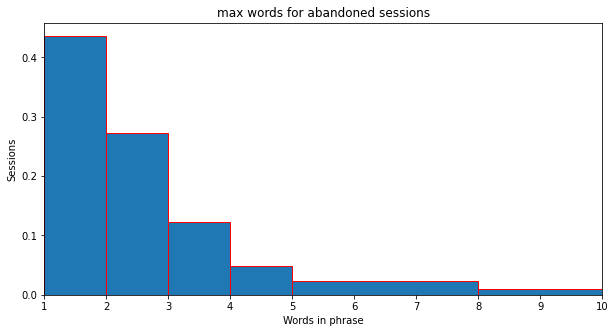

In [113]:
%%time
df_initial_symptoms = flattened_diagnosis[flattened_diagnosis['source']=='Initial']
searches_with_chief_complaints = df_search[df_search.session_id.isin(df_initial_symptoms.session_id.unique())]
searches_without_chief_complaints = df_search[~df_search.session_id.isin(searches_with_chief_complaints.session_id.unique())]
max_words_grouped_by_session = searches_without_chief_complaints.groupby(searches_without_chief_complaints.session_id)['phrase'].agg(lambda x: x.str.split("\\s+").str.len().max())

max_words_grouped_by_session.dropna(inplace=True)
max_words_counter_session = collections.Counter(max_words_grouped_by_session)
# max_words_counter_session.most_common(10)

fig, ax = plt.subplots(figsize=(10,5))

bins=[1,2,3,4,5,8,10,15,20]
# bins='auto'
plt.ylabel('Sessions')
plt.xlabel('Words in phrase');
plt.xlim(xmin=1, xmax = 10)
# ax.hist(max_words_grouped_by_session,bins=bins,edgecolor='red', density=False) 
ax.hist(max_words_grouped_by_session,bins=bins,edgecolor='red', density=True) 

ax.locator_params(axis='x', integer=True)

plt.title('max words for abandoned sessions')

In [114]:
%%time
max_words_sesssions_df = pd.DataFrame(data = max_words_counter_session.most_common(), columns=['max_words', 'sessions'])
max_words_sesssions_df= max_words_sesssions_df.loc[max_words_sesssions_df.index.repeat(max_words_sesssions_df.sessions)]
max_words_sesssions_df.drop('sessions', 1,inplace=True)
max_words_sesssions_df.describe()

Wall time: 4 ms


max_words
count  1525.000000
mean      3.108852
std       6.089982
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max     102.000000

# Fuzzy matching 

### Extract keywords score for tokens by phuzzy similarity

In [50]:
def phuzzy_extract(tokens, with_bigrams = False, score_cutoff=70, limit=10):
    if(with_bigrams):
        bigrams = list(ngrams(tokens, 2)) 
        tokens_with_bigrams = tokens + [ '_'.join(grams) for grams in bigrams]
        return dict((word,process.extractBests(word,keywords_set, scorer=fuzz.QRatio,score_cutoff=score_cutoff, limit=limit)) for word in tokens_with_bigrams)
    else:
        return dict((word,process.extractBests(word,keywords_set, scorer=fuzz.QRatio, score_cutoff=score_cutoff, limit=limit)) for word in tokens)

In [54]:
%%time
df_search_short_phrases['fuzzy_ratio_no_cutoff'] = df_search_short_phrases.phrase_tokens.progress_apply(lambda tokens: phuzzy_extract(tokens, with_bigrams = True, score_cutoff = 0))


  0%|          | 0/22244 [00:00<?, ?it/s]

Wall time: 7min 16s


In [109]:
HTML(pd.DataFrame(df_search_short_phrases[['phrase','fuzzy_ratio_no_cutoff']].head(2)).to_html(index=False))

### Get keywords and their scores from the phuzzy results dictionary

In [55]:
def get_keywords(fuzzy_dict):
    nested_list = ([v for k, v in fuzzy_dict.items()])
    flat_list = [item for sublist in nested_list for item in sublist]
    sorted_list = sorted(flat_list, key = lambda x: x[1], reverse=True)
    return set([item[0] for item in sorted_list])

In [56]:
import operator

def get_keywords_ratio(fuzzy_dict):
    nested = list(fuzzy_dict.values())
    list_tuples = ([item for sublist in nested for item in sublist])

    results = []

    for key, group in itertools.groupby(sorted(list_tuples), operator.itemgetter(0)):
        s = max(float(t[1]) for t in group)/100
        results.append((key, s))
    return dict(sorted(results, key = lambda x: x[1], reverse=True))

In [57]:
%%time
df_search_short_phrases['matching_keywords_no_cut_off'] = df_search_short_phrases[~df_search_short_phrases['fuzzy_ratio_no_cutoff'].isnull()]['fuzzy_ratio_no_cutoff'].apply(get_keywords)
df_search_short_phrases['keywords_fuzzy_score_no_cut_off'] = df_search_short_phrases[~df_search_short_phrases['fuzzy_ratio_no_cutoff'].isnull()]['fuzzy_ratio_no_cutoff'].apply(get_keywords_ratio)

HTML(pd.DataFrame(df_search_short_phrases[['matching_keywords_no_cut_off','keywords_fuzzy_score_no_cut_off']].head(3)).to_html(index=False))

Wall time: 718 ms


### Get  matching symptoms from the keywords results

In [58]:
def get_matching_symptoms(matching_keywords):
    nested_symptoms = [keywords_to_symptoms[key] for key in matching_keywords]
    flat_symptoms = sum(nested_symptoms, [])   #flatten
    return list(set(flat_symptoms))

In [ ]:
%%time
df_search_short_phrases['matching_symptoms_no_cut_off'] = df_search_short_phrases[~df_search_short_phrases['matching_keywords_no_cut_off'].isnull()]['matching_keywords_no_cut_off'].progress_apply(get_matching_symptoms)

### Get symptoms fuzzy score
Based on the maximum keywords score for a specific symptom

In [65]:
def get_symptoms_score_by_keywords(matching_keywords, func = max):
    symptoms_list = ([tuple((keywords_to_symptoms[k],v)) for k, v in matching_keywords.items()])
    nested_list=[[((item, order[1])) for item in order[0]] for order in symptoms_list]
    list_tuples = ([item for sublist in nested_list for item in sublist])

    results = []

    for key, group in itertools.groupby(sorted(list_tuples), operator.itemgetter(0)):
        s = func(list(float(t[1]) for t in group))
        results.append((key, s))
    return dict(sorted(results, key = lambda x: x[1], reverse=True))

In [64]:
%%time
df_search_short_phrases['symptoms_fuzzy_score_no_cut_off'] = df_search_short_phrases['keywords_fuzzy_score_no_cut_off'].progress_apply(get_symptoms_score_by_keywords)

  0%|          | 0/22244 [00:00<?, ?it/s]

Wall time: 4.05 s


In [122]:
HTML(pd.DataFrame(df_search_short_phrases[['phrase','matching_keywords_no_cut_off', 'keywords_fuzzy_score_no_cut_off','symptoms_fuzzy_score_no_cut_off']].head(1)).to_html(index=False))

# Semantic embeddings and cosign similarity

## Sentence Transformers

### msmarco-distilbert-dot-v5

#### Create embeddings for search phrases, symptoms, keywords and symptom tokens

In [139]:
%%time
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/msmarco-distilbert-dot-v5')
model


Wall time: 9.7 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [342]:
searches_bert = single_symptom_serches.drop_duplicates(["session_id",'phrase', "id"])
searches_bert['phrase'] = searches_bert['phrase'].str.lower()



In [343]:
%%time
searches_bert['phrase'] = searches_bert['phrase'].str.lower()
phrase_embeddings = model.encode(searches_bert.phrase.to_list(), show_progress_bar=True)
symptoms_embeddings = model.encode(df_keywords.symptom_id.str.replace('_', ' ').unique(), show_progress_bar=True)
keywords_embeddings = model.encode(list(keywords_set), show_progress_bar=True)
symptoms_tokens_embeddings =  model.encode(list(symptoms_tokens_set), show_progress_bar=True)

phrase_embeddings.shape ,  symptoms_embeddings.shape, keywords_embeddings.shape, searches_bert.phrase.shape, symptoms_tokens_embeddings.shape

Batches:   0%|          | 0/1299 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Wall time: 2min 4s


((41553, 768), (884, 768), (1926, 768), (41553,), (753, 768))

In [278]:
%%time
lst = list(set(searches_bert.id))
dict_symptoms = dict(zip(lst, range(len(lst))))
clusters_by_selected_symptoms = searches_bert.id.progress_apply(lambda x: dict_symptoms[x])

Pandas Apply:   0%|          | 0/12050 [00:00<?, ?it/s]

Wall time: 56 ms


In [311]:
%%time
tsne_bert = TSNE(n_components=2, perplexity=10).fit_transform(phrase_embeddings)

Wall time: 1min 56s


#### DB-SCAN

In [335]:
%%time
clusters_dbscan = DBSCAN(eps=10, min_samples=2, n_jobs = -1).fit_predict(phrase_embeddings)
print(f'number of clusters: {len(list(set(clusters_dbscan)))}')
# cluster.tsneplot(score=tsne_bert, show = True, colorlist=clusters_dbscan, dim = (10,8))

number of clusters: 1
Wall time: 11.7 s


In [326]:
import seaborn as sns

def plot_clusters(tsne_bert,clusters_by_selected_symptoms, clusters_by_algo, title):
    df_subset = pd.DataFrame()
    plt.figure(figsize=(16,8))


    ax1 = plt.subplot(1, 2, 1)
    df_subset['tsne-2d-one'] = tsne_bert[:,0]
    df_subset['tsne-2d-two'] = tsne_bert[:,1]
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue=clusters_by_selected_symptoms.to_numpy(),
        palette='deep',
        data = df_subset,
        legend=False,
        ax = ax1
    ).set(title='Clusters by selected_symptoms')

    ax2 = plt.subplot(1, 2, 2)
    df_subset['tsne-2d-one'] = tsne_bert[:,0]
    df_subset['tsne-2d-two'] = tsne_bert[:,1]
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue=clusters_by_algo,
        palette='deep',
        data=df_subset,
        legend=False,
        ax = ax2
    ).set(title=title)
    plt.show()

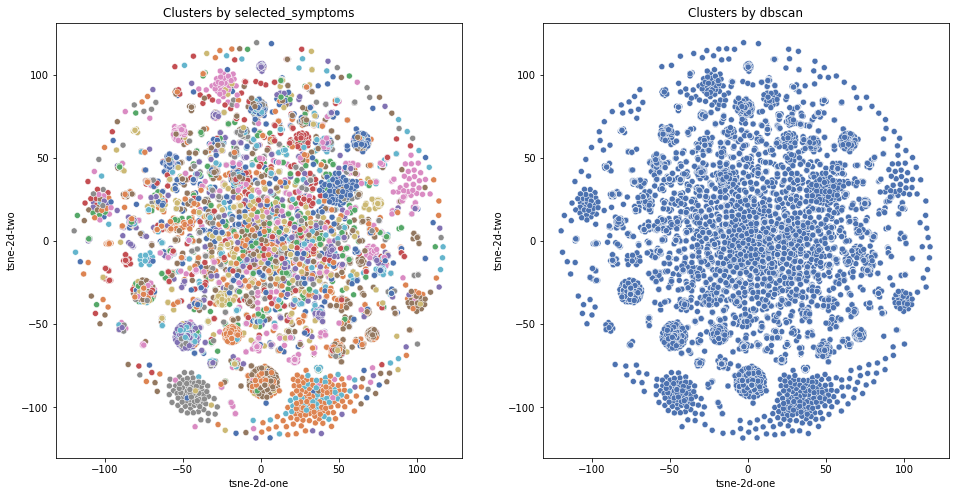

Wall time: 1.74 s


In [336]:
%%time
plot_clusters(tsne_bert,clusters_by_selected_symptoms, clusters_dbscan, 'Clusters by dbscan')

In [322]:
def check_clusters(clusters, print_clusters = True, rows = 5):
    df_clustered_phrase = pd.concat([searches_bert.phrase.reset_index(), pd.Series(clusters).reset_index()], axis=1)
    df_clustered_phrase.drop(columns=['index'], inplace=True)
    df_clustered_phrase.rename(columns={df_clustered_phrase.columns[1]: 'cluster'}, inplace=True)
    df_clustered_phrase = df_clustered_phrase.groupby('cluster').agg({'phrase':lambda x: list(set(list(x)))})

    mask_diff_phrase = df_clustered_phrase['phrase'].apply(lambda x: [' '.join(w.split()) for w in x]).apply(lambda x: len(set(x)) > 1)
    num_of_clusters_with_diff_phrases =  df_clustered_phrase[mask_diff_phrase].shape[0]

    print (f'\nNumber of clusters with diff phrases: {num_of_clusters_with_diff_phrases}')
    
    if (print_clusters):
        display(HTML(df_clustered_phrase.head(rows).to_html(index=True)))

In [337]:
%%time
check_clusters(clusters_dbscan, print_clusters = True)



Number of clusters with diff phrases: 1


Wall time: 32.7 ms


#### K-Means

In [938]:
%%time
from nltk.cluster import KMeansClusterer
import nltk
num_clusters=30
kclusterer = KMeansClusterer(num_clusters, distance=nltk.cluster.util.cosine_distance, repeats=1, avoid_empty_clusters = True)
kmeans_clusters = kclusterer.cluster(phrase_embeddings, assign_clusters=True)


Wall time: 1min 6s


In [937]:
%%time
check_clusters(kmeans_clusters, print_clusters = True, rows=num_clusters)


Number of clusters with diff phrases: 10


Wall time: 23 ms


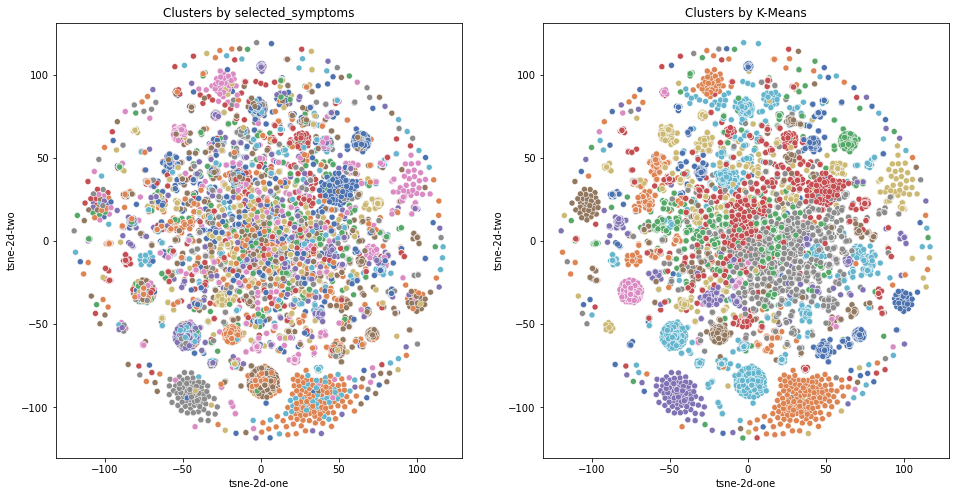

Wall time: 564 ms


In [943]:
%%time
plot_clusters(tsne_bert,clusters_by_selected_symptoms, kmeans_clusters, 'Clusters by K-Means')

#### Semantic search
Appy semantic search by cosine similarity

##### Semantic search functions

In [76]:
def get_matching_symptoms_by_symptoms_tokens(symptoms_tokens):
    nested_symptoms = [symptom_tokens_to_symptoms[token] for token in symptoms_tokens]
    flat_symptoms = sum(nested_symptoms, [])   #flatten
    return list(set(flat_symptoms))

def get_semantic_symptoms_direct(phrase_embeddings, symptoms_embeddings, top_k=1):
    semantic_search_symptoms = util.semantic_search(phrase_embeddings, symptoms_embeddings, top_k= top_k, query_chunk_size = 1000)
    nested_symptoms_list = [[x['corpus_id'] for x in y] for y in semantic_search_symptoms]
    semantic_symtpoms_direct = [[df_keywords.symptom_id.unique()[j] for j in i] for i in nested_symptoms_list]
    return semantic_symtpoms_direct

def get_semantic_symptoms_by_keywords(phrase_embeddings, keywords_embeddings, top_k=1):
    semantic_search_keywords = util.semantic_search(phrase_embeddings, keywords_embeddings, top_k = top_k, query_chunk_size = 1000)
    nested_keywords_list = [[x['corpus_id'] for x in y] for y in semantic_search_keywords]
    semantic_symtpoms_by_keywords = [get_matching_symptoms([list(keywords_set)[j] for j in i]) for i in nested_keywords_list]
    return semantic_symtpoms_by_keywords

def get_semantic_symptoms_by_symptoms_tokens(phrase_embeddings, symptoms_tokens_embeddings, top_k=1):
    if symptoms_tokens_embeddings is None:
        return None
    semantic_search_symptoms_tokens = util.semantic_search(phrase_embeddings, symptoms_tokens_embeddings, top_k = top_k, query_chunk_size = 1000)
    nested_symptoms_tokens_list = [[x['corpus_id'] for x in y] for y in semantic_search_symptoms_tokens]
    semantic_symtpoms_by_symptoms_tokens = [get_matching_symptoms_by_symptoms_tokens([list(symptoms_tokens_set)[j] for j in i]) for i in nested_symptoms_tokens_list]
    return semantic_symtpoms_by_symptoms_tokens

def get_semantic_keywords(phrase_embeddings, keywords_embeddings, top_k=1):
    semantic_search_keywords = util.semantic_search(phrase_embeddings, keywords_embeddings, top_k = top_k, query_chunk_size = 1000)
    nested_keywords_list = [dict([tuple((list(keywords_set)[x['corpus_id']], round(x['score'], 2))) for x in y]) for y in tqdm(semantic_search_keywords)]
    return nested_keywords_list

In [158]:
# This function can calculate the symptoms by applying the func which can be max or sum on the token scores
def get_symptoms_score_by_symptom_tokens_func(matching_symptom_tokens, func):
    symptoms_list = ([tuple((symptom_tokens_to_symptoms[k],v)) for k, v in matching_symptom_tokens.items()])
    nested_list=[[((item, order[1])) for item in order[0]] for order in symptoms_list]
    list_tuples = ([item for sublist in nested_list for item in sublist])

    results = []

    for key, group in itertools.groupby(sorted(list_tuples), operator.itemgetter(0)):
        s = func(round(float(t[1]),2) for t in group)
        results.append((key, round(s,2)))
    return dict(sorted(results, key = lambda x: x[1], reverse=True))

In [150]:
def get_semantic_symptoms_tokens(phrase_embeddings, symptoms_tokens_embeddings, top_k=1):
    semantic_search_symptoms_tokens = util.semantic_search(phrase_embeddings, symptoms_tokens_embeddings, top_k = top_k, query_chunk_size = 1000)
    nested_symptoms_tokens_list = [dict([tuple((list(symptoms_tokens_set)[x['corpus_id']], round(x['score'], 2))) for x in y]) for y in tqdm(semantic_search_symptoms_tokens)]
    return nested_symptoms_tokens_list

##### Get symptoms score by symptom tokens sum

#### Save semantic score to dataframe

In [ ]:
# %%time
semantic_keywords = get_semantic_keywords(phrase_embeddings, keywords_embeddings, top_k=all_symptoms)
merged_symptoms_all_scores_no_duplicates['semantic_keywords_score'] = semantic_keywords
merged_symptoms_all_scores_no_duplicates['semantic_symptoms_score'] = merged_symptoms_all_scores_no_duplicates['semantic_keywords_score'].progress_apply(get_symptoms_score_by_keywords)

In [ ]:
%%time
semantic_symptom_tokens_score = get_semantic_symptoms_tokens(phrase_embeddings, symptoms_tokens_embeddings, top_k=all_symptoms)
merged_symptoms_all_scores_no_duplicates['semantic_symptom_tokens_score'] = semantic_symptom_tokens_score
merged_symptoms_all_scores_no_duplicates['semantic_symptoms_score_by_tokens_sum'] = merged_symptoms_all_scores_no_duplicates['semantic_symptom_tokens_score'].progress_apply(lambda x: get_symptoms_score_by_symptom_tokens_func(x, sum))
merged_symptoms_all_scores_no_duplicates['semantic_symptoms_score_by_tokens_max'] = merged_symptoms_all_scores_no_duplicates['semantic_symptom_tokens_score'].progress_apply(lambda x: get_symptoms_score_by_symptom_tokens_func(x, max))

#### Get success of searches

In [49]:
def get_success_searches_ratio(semantic_symtpoms_direct, semantic_symtpoms_by_keywords, semantic_symtpoms_by_symptoms_tokens, should_print = False):
    hits_direct_symtoms = 0
    hits_symptoms_by_keywords = 0
    hits_symptoms_by_symptoms_tokens = 0
    # hits_symptoms_by_symptoms_tokens_sum = 0
    counter = 0
    for row in tqdm(searches_bert.itertuples()):
        if (row.id in semantic_symtpoms_direct[counter]):
            hits_direct_symtoms +=1
        if (row.id in semantic_symtpoms_by_keywords[counter]):
            hits_symptoms_by_keywords +=1
        if  ((semantic_symtpoms_by_symptoms_tokens is not None) and row.id in semantic_symtpoms_by_symptoms_tokens[counter]):
            hits_symptoms_by_symptoms_tokens +=1      
        counter +=1

    ratio_direct = hits_direct_symtoms / searches_bert.shape[0]
    ratio_by_keywords = hits_symptoms_by_keywords / searches_bert.shape[0]
    ratio_by_symptoms_tokens = hits_symptoms_by_symptoms_tokens / searches_bert.shape[0]
    # ratio_by_symptoms_tokens_sum = hits_symptoms_by_symptoms_tokens_sum / searches_bert.shape[0]

    if (should_print):
        print(f'Ratio of successful searches by semantic search for symptom: {ratio_direct:.2f}')
        print(f'Ratio of successful searches by semantic search for keyword: {ratio_by_keywords:.2f}')
        print(f'Ratio of successful searches by semantic search for symptom tokens: {ratio_by_symptoms_tokens:.2f}')
        # print(f'Ratio of successful searches by semantic search for symptom tokens sum: {ratio_by_symptoms_tokens_sum:.2f}')

    # return ratio_direct, ratio_by_keywords, ratio_by_symptoms_tokens, ratio_by_symptoms_tokens_sum
    return ratio_direct, ratio_by_keywords, ratio_by_symptoms_tokens

In [89]:
%%time 

def get_semantic_search_results(phrase_embeddings, symptoms_embeddings, keywords_embeddings, symptoms_tokens_embeddings, limit = 30):
    ratio_direct_list = []
    ratio_by_keywords_list = []
    ratio_by_symptoms_tokens_list = []
    ratio_by_symptoms_tokens_sum_list = []

    for i in tqdm(range (1, limit + 1)):
        print (f'calculating for top_k={i}')
        if (symptoms_embeddings):
            semantic_symtpoms_direct = get_semantic_symptoms_direct(phrase_embeddings, symptoms_embeddings, top_k= i)
        semantic_symtpoms_by_keywords = get_semantic_symptoms_by_keywords(phrase_embeddings, keywords_embeddings, top_k= i)
        if (symptoms_tokens_embeddings):
            semantic_symtpoms_by_symptoms_tokens = get_semantic_symptoms_by_symptoms_tokens(phrase_embeddings, symptoms_tokens_embeddings, top_k= i)
        
        # ratio_direct, ratio_by_keywords, ratio_by_symptoms_tokens, ratio_by_symptoms_tokens_sum = get_success_searches_ratio(semantic_symtpoms_direct, semantic_symtpoms_by_keywords, semantic_symtpoms_by_symptoms_tokens,semantic_symtpoms_by_symptoms_tokens_sum, should_print = True)
        ratio_direct, ratio_by_keywords, ratio_by_symptoms_tokens = get_success_searches_ratio(semantic_symtpoms_direct, semantic_symtpoms_by_keywords, semantic_symtpoms_by_symptoms_tokens, should_print = True)
        
        ratio_direct_list.append(ratio_direct)
        ratio_by_keywords_list.append(ratio_by_keywords)
        ratio_by_symptoms_tokens_list.append(ratio_by_symptoms_tokens)
        # ratio_by_symptoms_tokens_sum_list.append(ratio_by_symptoms_tokens_sum)
        
    results_semantic_search_df = pd.DataFrame({'ratio_direct_list': ratio_direct_list, 'ratio_by_keywords_list': ratio_by_keywords_list, 'ratio_by_symptoms_tokens_list': ratio_by_symptoms_tokens_list})
    return results_semantic_search_df

Wall time: 0 ns


In [ ]:
distillbert_semantic_Serach_results_df = get_semantic_search_results(phrase_embeddings, symptoms_embeddings, keywords_embeddings, symptoms_tokens_embeddings,limit = 10)

In [51]:
from matplotlib.ticker import FormatStrFormatter


def plot_semantic_results(results_semantic_search_df, title):   
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, results_semantic_search_df.shape[0]+1), results_semantic_search_df.ratio_direct_list, label = 'symptoms')
    plt.plot(range(1, results_semantic_search_df.shape[0]+1), results_semantic_search_df.ratio_by_keywords_list, label = 'keywords')
    plt.plot(range(1, results_semantic_search_df.shape[0]+1), results_semantic_search_df.ratio_by_symptoms_tokens_list, label = 'symptom tokens')
    plt.xticks(range(0, results_semantic_search_df.shape[0]+2, 2))
    plt.xlabel("top-k")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(title)
    plt.grid()
    
    ax=plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plt.show()

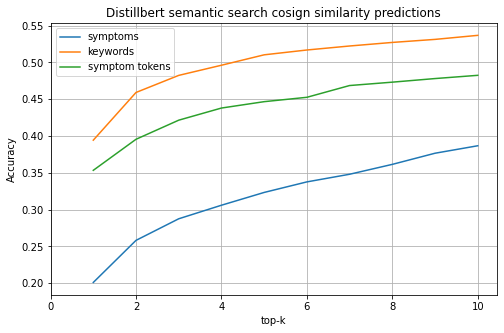

In [173]:
plot_semantic_results(distillbert_semantic_Serach_results_df, 'Distillbert semantic search cosign similarity predictions')

### S-Biomed-Roberta-snli-multinli-stsb

In [510]:
%%time
from sentence_transformers import SentenceTransformer

model_s_biomed = SentenceTransformer('pritamdeka/S-Biomed-Roberta-snli-multinli-stsb')
model_s_biomed


Wall time: 11.9 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 75, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [117]:
%%time
phrase_embeddings_biomed = model_s_biomed.encode(searches_bert.phrase.to_list(), show_progress_bar=True)
symptoms_embeddings_biomed = model_s_biomed.encode(df_keywords.symptom_id.str.replace('_', ' ').unique(), show_progress_bar=True)
keywords_embeddings_biomed = model_s_biomed.encode(list(keywords_set), show_progress_bar=True)
symptoms_tokens_embeddings_biomed =  model_s_biomed.encode(list(symptoms_tokens_set), show_progress_bar=True)
phrase_embeddings_biomed.shape ,  symptoms_embeddings_biomed.shape, keywords_embeddings_biomed.shape, searches_bert.phrase.shape,

Batches:   0%|          | 0/377 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Wall time: 1min 3s


((12050, 768), (884, 768), (1926, 768), (12050,))

In [ ]:
scores_biomed_roberta_df = get_semantic_search_results(phrase_embeddings_biomed, symptoms_embeddings_biomed, keywords_embeddings_biomed, symptoms_tokens_embeddings_biomed)

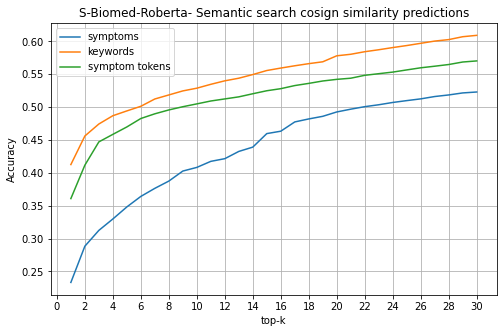

In [120]:
plot_semantic_results(scores_biomed_roberta_df, 'S-Biomed-Roberta- Semantic search cosign similarity predictions')

### all-mpnet-base-v2

In [62]:
%%time
from sentence_transformers import SentenceTransformer

model_all_mpnet_base_v2 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model_all_mpnet_base_v2

Wall time: 10.4 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [64]:
%%time
phrase_embeddings_all_mpnet_base_v2 = model_all_mpnet_base_v2.encode(searches_bert.phrase.to_list(), show_progress_bar=True)
symptoms_embeddings_all_mpnet_base_v2 = model_all_mpnet_base_v2.encode(df_keywords.symptom_id.str.replace('_', ' ').unique(), show_progress_bar=True)
keywords_embeddings_all_mpnet_base_v2 = model_all_mpnet_base_v2.encode(list(keywords_set), show_progress_bar=True)
symptoms_tokens_embeddings_all_mpnet_base_v2 =  model_all_mpnet_base_v2.encode(list(symptoms_tokens_set), show_progress_bar=True)
phrase_embeddings_all_mpnet_base_v2.shape ,  symptoms_embeddings_all_mpnet_base_v2.shape, keywords_embeddings_all_mpnet_base_v2.shape, searches_bert.phrase.shape,

Batches:   0%|          | 0/695 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Wall time: 1min 46s


((22225, 768), (884, 768), (1926, 768), (22225,))

In [ ]:
scores_all_mpnet_base_v2_df = get_semantic_search_results(phrase_embeddings_all_mpnet_base_v2, symptoms_embeddings_all_mpnet_base_v2, keywords_embeddings_all_mpnet_base_v2, symptoms_tokens_embeddings_all_mpnet_base_v2, limit = 10)

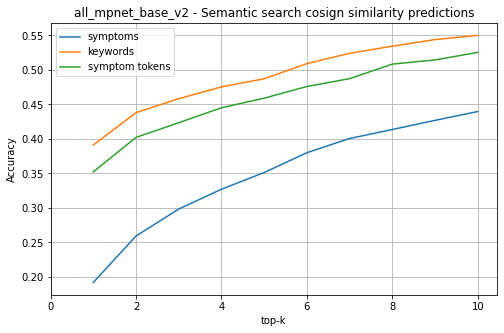

In [66]:
plot_semantic_results(scores_all_mpnet_base_v2_df, 'all_mpnet_base_v2 - Semantic search cosign similarity predictions')

### MimicIII-Roberta

In [ ]:
%%time
from sentence_transformers import SentenceTransformer

model_mimiciii_roberta = SentenceTransformer('Models/mimiciii_roberta_10e_128b')
model_mimiciii_roberta



In [500]:
%%time
phrase_embeddings_mimiciii_roberta = model_mimiciii_roberta.encode(searches_bert.phrase.to_list(), show_progress_bar=True)
symptoms_embeddings_mimiciii_roberta = model_mimiciii_roberta.encode(df_keywords.symptom_id.str.replace('_', ' ').unique(), show_progress_bar=True)
keywords_embeddings_mimiciii_roberta = model_mimiciii_roberta.encode(list(keywords_set), show_progress_bar=True)
symptoms_tokens_embeddings_mimiciii_roberta =  model_mimiciii_roberta.encode(list(symptoms_tokens_set), show_progress_bar=True)


Batches:   0%|          | 0/377 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Wall time: 1min 26s


In [ ]:
scores_mimiciii_roberta_df = get_semantic_search_results(phrase_embeddings_mimiciii_roberta, symptoms_embeddings_mimiciii_roberta, keywords_embeddings_mimiciii_roberta, symptoms_tokens_embeddings_mimiciii_roberta, limit = 10)

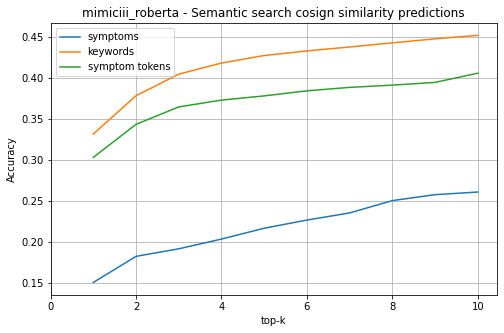

In [504]:
plot_semantic_results(scores_mimiciii_roberta_df, 'mimiciii_roberta - Semantic search cosign similarity predictions')

### BlueBert

In [27]:
searches_bert = merged_symptoms_all_scores_no_duplicates.drop_duplicates(["session_id",'phrase', "id"])


In [ ]:
from sentence_transformers import SentenceTransformer

model_bluebert = SentenceTransformer('bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16')

In [366]:
%%time
phrase_embeddings_bluebert = model_bluebert.encode(searches_bert.phrase.to_list(), show_progress_bar=True)
symptoms_embeddings_bluebert = model_bluebert.encode(df_keywords.symptom_id.str.replace('_', ' ').unique(), show_progress_bar=True)
keywords_embeddings_bluebert = model_bluebert.encode(list(keywords_set), show_progress_bar=True)
symptoms_tokens_embeddings_bluebert =  model_bluebert.encode(list(symptoms_tokens_set), show_progress_bar=True)


Batches:   0%|          | 0/696 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Wall time: 32min 25s


In [ ]:
scores_bluebert_df = \
    get_semantic_search_results(phrase_embeddings_bluebert, symptoms_embeddings_bluebert, keywords_embeddings_bluebert, symptoms_tokens_embeddings_bluebert, limit = 10)

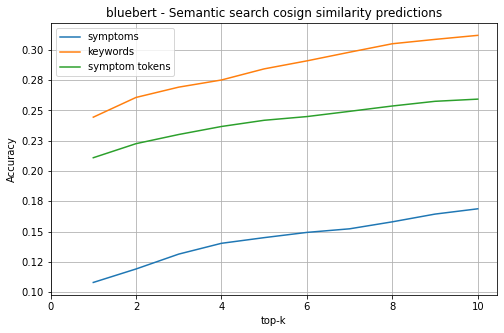

In [395]:
plot_semantic_results(scores_bluebert_df, 'bluebert - Semantic search cosign similarity predictions')

### enoriega/kw_pubmed_1000_0.0003
This model is a fine-tuned version of microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext on the keyword_pubmed_dataset dataset

In [ ]:
model_biomed_pubmed = SentenceTransformer('enoriega/kw_pubmed_1000_0.0003')


In [46]:
%%time
phrase_embeddings_biomed_pubmed = model_biomed_pubmed.encode(searches_bert.phrase.to_list(), show_progress_bar=True)
symptoms_embeddings_biomed_pubmed = model_biomed_pubmed.encode(df_keywords.symptom_id.str.replace('_', ' ').unique(), show_progress_bar=True)
keywords_embeddings_biomed_pubmed = model_biomed_pubmed.encode(list(keywords_set), show_progress_bar=True)
symptoms_tokens_embeddings_biomed_pubmed =  model_biomed_pubmed.encode(list(symptoms_tokens_set), show_progress_bar=True)

Batches:   0%|          | 0/695 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Wall time: 1min 41s


In [47]:
phrase_embeddings_biomed_pubmed.shape, symptoms_embeddings_biomed_pubmed.shape, keywords_embeddings_biomed_pubmed.shape, symptoms_tokens_embeddings_biomed_pubmed.shape

((22225, 768), (884, 768), (1926, 768), (753, 768))

In [ ]:
scores_biomed_pubmed_df = \
    get_semantic_search_results(phrase_embeddings_biomed_pubmed, symptoms_embeddings_biomed_pubmed, keywords_embeddings_biomed_pubmed, symptoms_tokens_embeddings_biomed_pubmed, limit = 10)

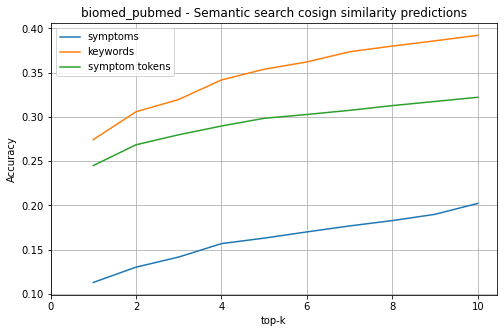

In [61]:
plot_semantic_results(scores_biomed_pubmed_df, 'biomed_pubmed - Semantic search cosign similarity predictions')

## Transformers results summary

After analyzing the results for scores by symptoms / keywords / symptom tokens for different transformers <br>
we can see from the plots above that we achieve the best results for **all-mpnet-base-v2** transformer <br> 
top-5:   50%  accuracy <br>
top-10:  55%  accuracy

# Ranking

## Load preprocessed data from file (optional)

In [98]:
%%time
# merged_symptoms_all_scores_no_duplicates = pd.read_csv("data/preprocessed_data.csv", index_col=0, 
merged_symptoms_all_scores_no_duplicates = pd.read_csv("data/preprocessed_data_without_abandoned.csv", index_col=0, 
   converters={#"phrase_tokens": literal_eval,
               # "search_responses": literal_eval,
               # "fuzzy_ratio_no_cutoff": literal_eval,
                # "matching_keywords_no_cut_off": literal_eval,
                # "matching_symptoms_no_cut_off": literal_eval,
                "symptoms_score_no_cut_off": literal_eval,
               # "keywords_fuzzy_score_no_cut_off": literal_eval,
               "symptoms_fuzzy_score_no_cut_off": literal_eval,
               # "evidences": literal_eval,
               # "semantic_keywords_score": literal_eval,
               "semantic_symptoms_score": literal_eval,
               # 'semantic_symptom_tokens_score': literal_eval,
                # 'semantic_symptoms_score_by_tokens_max':literal_eval,
                # 'semantic_symptoms_score_by_tokens_sum':literal_eval,
                'semantic_symptoms_score_all_mpnet_base_v2':literal_eval,
               # 'semantic_symptoms_score_all_mpnet_base_v2_keywords_mean':literal_eval,
                 # 'semantic_symptoms_score_mimiciii_roberta':literal_eval
              })

merged_symptoms_all_scores_no_duplicates.shape

Wall time: 5min 27s


(15005, 47)

## Misc functions

### get_index
Gets index of an object in the list. <br>
If not exists - return None

In [99]:
def get_index(symptoms_list, selected_symptom):
    return int(symptoms_list.index(selected_symptom)) if selected_symptom in symptoms_list else None

### convert_symptoms_to_symptom_groups
Converts list of symptoms to list of relevant symptoms groups (categories)

In [100]:
def convert_symptoms_to_symptom_groups(symptoms_list):
    symptom_groups = []
    for symptom in symptoms_list:
        temp_group_list = symptoms_to_groups.get(symptom, [])
        symptom_groups = symptom_groups + temp_group_list
    return list(dict.fromkeys(symptom_groups))    #using dict.fromkeys in order to keep the order of the unique groups

In [964]:
convert_symptoms_to_symptom_groups(df_symptom_mappings.symptom_id.to_list()[:10])

['abdominal discomfort']

### get_group_index
Get index of highest symptom group from list of groups <br>
Pay attention - there might be multiple selected symtpom groupd because one selected seymptom can relate to multiple symtpom groups, according to symptom mappings. <br>
Therefore, this function recieves a list of selected symptom groupd and a list of predicted symptom groups and return the highest rank of on of the selected groups in the predicted list. <br>
If doesn't exist - return 50 - the lowest rank of symptom group.

In [101]:
def get_group_index(predicted_groups, selected_groups):
    temp = []
    try:
        temp = [int(predicted_groups.index(group)) if group in predicted_groups else None for group in selected_groups]
        if (not temp):
            return 50
        result = sorted(temp, key=lambda x: (x is None, x))[0]
        return 50 if result == None else result
    except Exception:
        print (f'temp={temp}')
        print (f'predicted_groups={predicted_groups}')
        print (f'selected_groups={selected_groups}')
        raise Exception('Excption thrown from get_group_index')
 

In [634]:
index1 = 1
x1 =convert_symptoms_to_symptom_groups(list(filtered_abandones_searches.iloc[index1].mixed_score.keys())[:1])
x2 = convert_symptoms_to_symptom_groups([filtered_abandones_searches.iloc[index1].id])
x1,x2

(['skin/nails/hair alteration-discoloration'], ['urinary system disorders'])

In [635]:
get_group_index(x1,x2)

50

### get_mixed_score
Gets mixed score for symptom predictions, according to fuzzy and  semantic similarity and symptom popularity buckets. <br>
The default mixed score is calculated by (symptom_semantic_score + symptom_fuzzy_score) * (1 + symptom_popularity * popularity_factor) <br>
'semantic_score_column_name' - is the column name whre to get the semantic score from. Default transformer = 'msmarco-distilbert-dot-v5' <br>
if you want to to use best transformer - need to change to semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2'

In [137]:
%%time
from enum import Enum 

# symprom popularity buckets
symptom_pop_no_filter =  get_symptom_popularity()
symptoms_pop_female = get_symptom_popularity(gender = 'FEMALE', min_age = None, max_age = None)
symptoms_pop_male = get_symptom_popularity(gender = 'MALE', min_age = None, max_age = None)
symptoms_pop_age_bucket1 = get_symptom_popularity(min_age = None, max_age = 18)
symptoms_pop_age_bucket2 = get_symptom_popularity(min_age = 19, max_age = 44)
symptoms_pop_age_bucket3 = get_symptom_popularity(min_age = 45, max_age = 64)
symptoms_pop_age_bucket4 = get_symptom_popularity(min_age = 65, max_age = 84)
symptoms_pop_age_bucket5 = get_symptom_popularity(min_age = 85, max_age = None)
symptoms_pop_male_age_bucket1 = get_symptom_popularity(gender = 'MALE', min_age = None, max_age = 18)
symptoms_pop_male_age_bucket2 = get_symptom_popularity(gender = 'MALE', min_age = 19, max_age = 44)
symptoms_pop_male_age_bucket3 = get_symptom_popularity(gender = 'MALE', min_age = 45, max_age = 64)
symptoms_pop_male_age_bucket4 = get_symptom_popularity(gender = 'MALE', min_age = 65, max_age = 84)
symptoms_pop_male_age_bucket5 = get_symptom_popularity(gender = 'MALE', min_age = 85, max_age = None)
symptoms_pop_female_age_bucket1 = get_symptom_popularity(gender = 'FEMALE', min_age = None, max_age = 18)
symptoms_pop_female_age_bucket2 = get_symptom_popularity(gender = 'FEMALE', min_age = 19, max_age = 44)
symptoms_pop_female_age_bucket3 = get_symptom_popularity(gender = 'FEMALE', min_age = 45, max_age = 64)
symptoms_pop_female_age_bucket4 = get_symptom_popularity(gender = 'FEMALE', min_age = 64, max_age = 84)
symptoms_pop_female_age_bucket5 = get_symptom_popularity(gender = 'FEMALE', min_age = 84, max_age = None)


# Popularity filter for manipulating popularity buckets
class Popularity_Filter(Enum):
    IGNORE = 0    # Ignores symptom popularity and doesn't use it for the mixed score
    AGE = 1       # Considers  only age buckets for symptom popularity
    GENDER = 2    # Considers gender for symptom popularity only age buckets for symptom popularity
    GENDER_AGE = 3    # Considers  both gender and age buckets for symptom popularity
    # GENDER_AGE_DIABETES = 4
    ALL = 5    # Considers  all the records for symptoms popularity, without filtering

def get_mixed_score(row, top_n = None, pop_filter = Popularity_Filter.ALL, popularity_factor = 1, use_popularity_only = False, \
                    sort_scores_by_top_symptom_popularity = False, fuzzy_factor = 1, semantic_score_column_name = 'semantic_symptoms_score', \
                    top_similarity_scores_ratio_for_popularity = 1, popularity_operator = operator.mul):
    
    results_dict = {}
    
    if (pop_filter == Popularity_Filter.GENDER):
        if (row.gender == 'FEMALE'):
            symptom_popularity = symptoms_pop_female
        else:
            symptom_popularity = symptoms_pop_male
    elif (pop_filter == Popularity_Filter.AGE):
        if (row.age <= 18):
            symptom_popularity = symptoms_pop_age_bucket1
        elif (row.age <= 44):
            symptom_popularity = symptoms_pop_age_bucket2
        elif (row.age <= 64):
            symptom_popularity = symptoms_pop_age_bucket3
        elif (row.age <= 84):
            symptom_popularity = symptoms_pop_age_bucket4
        else:
            symptom_popularity = symptoms_pop_age_bucket5       
    elif (pop_filter == Popularity_Filter.IGNORE):
        symptom_popularity = {}
    elif (pop_filter == Popularity_Filter.GENDER_AGE):
        if (row.gender == 'FEMALE'):
            if (row.age <= 18):
                symptom_popularity = symptoms_pop_female_age_bucket1
            elif (row.age <= 44):
                symptom_popularity = symptoms_pop_female_age_bucket2
            elif (row.age <= 64):
                symptom_popularity = symptoms_pop_female_age_bucket3
            elif (row.age <= 84):
                symptom_popularity = symptoms_pop_female_age_bucket4
            else:
                symptom_popularity = symptoms_pop_female_age_bucket5  
        else:
            if (row.age <= 18):
                symptom_popularity = symptoms_pop_male_age_bucket1
            elif (row.age <= 44):
                symptom_popularity = symptoms_pop_male_age_bucket2
            elif (row.age <= 64):
                symptom_popularity = symptoms_pop_male_age_bucket3
            elif (row.age <= 84):
                symptom_popularity = symptoms_pop_male_age_bucket4
            else:
                symptom_popularity = symptoms_pop_male_age_bucket5  
    else:
        symptom_popularity = symptom_pop_no_filter

        
        

    top_n_symptoms = df_keywords.symptom_id.unique()
    if ('numbness_in_one_lower_limb' not in top_n_symptoms):
        top_n_symptoms = np.append(top_n_symptoms, 'numbness_in_one_lower_limb')
    
    for symptom in top_n_symptoms:
        popularity_result = 1 + popularity_operator(symptom_popularity.get(symptom,0), popularity_factor)
        # popularity_result = popularity_operator(1 + symptom_popularity.get(symptom,0), popularity_factor)

        
        if (use_popularity_only):
            results_dict[symptom] = popularity_result
        elif (sort_scores_by_top_symptom_popularity):
            results_dict[symptom] = round(((row[semantic_score_column_name].get(symptom,0) + fuzzy_factor * row.symptoms_fuzzy_score_no_cut_off.get(symptom,0))),3)
        else:
            similarity_sum = row[semantic_score_column_name].get(symptom,0) + fuzzy_factor * row.symptoms_fuzzy_score_no_cut_off.get(symptom,0)
            if (top_similarity_scores_ratio_for_popularity == 1):
                results_dict[symptom] = similarity_sum * popularity_result
            else:
                results_dict[symptom] = similarity_sum
                
    if (top_similarity_scores_ratio_for_popularity < 1):
        temp_list = sorted(results_dict.items(), key=lambda x: x[1],  reverse=True)
        stop_at = int(len(temp_list) * top_similarity_scores_ratio_for_popularity)
        for i, (symptom, score) in enumerate (temp_list):
            popularity_result = popularity_operator(1 + symptom_popularity.get(symptom,0), popularity_factor)
            temp_list[i] = (symptom, score * popularity_result)
            if (i>= stop_at-1): 
                break
        return dict(sorted(temp_list, key=lambda x: x[1], reverse=True))
    
    if (sort_scores_by_top_symptom_popularity):
        results_dict = dict(sorted(results_dict.items(), key=lambda x: x[1],  reverse=True)[:top_n])
        results_dict = results_dict.fromkeys(results_dict, 0)
        for key in list(results_dict.keys()):
            results_dict[key] = symptom_popularity.get(key,0)
    return dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))

Wall time: 1.77 s


#### Quick mixed_score function test

In [126]:
%%time
results_matrix['mixed_score'] =  \
    results_matrix.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 10, fuzzy_factor = 0, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 0.2, \
                   popularity_operator = operator.pow), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 2min 10s


count    15005.000000
mean       146.613595
std        235.420972
min          0.000000
25%          1.000000
50%         10.000000
75%        205.000000
max        884.000000
dtype: float64

In [121]:
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_5

0.41752749083638785

## Prepare data for Ranking analysis

In [106]:
results_matrix = merged_symptoms_all_scores_no_duplicates

results_matrix.shape

(15005, 47)

In [94]:
#max number of symptoms to combine 5 groups
max_symptoms_5_groups = pd.Series(groups_to_symptoms.values()).apply(lambda x: len(x)).nlargest(5).sum()
max_symptoms_5_groups

381

## Different models with distilbert transformer

### Semantic score only

In [154]:
results_matrix.apply(lambda x: get_index(list(x.semantic_symptoms_score.keys()), x.id), axis=1 ).astype("Int64").describe()

count    22152.000000
mean       192.890800
std        248.510497
min          0.000000
25%          4.000000
50%         57.000000
75%        345.000000
max        881.000000
dtype: float64

In [155]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.semantic_symptoms_score.keys()), x.id), axis=1 ).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['semantic_score_only'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df


semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        fuzzy_score_only  \
count           22244.00   
mean              364.97   
std               419.90   
min                 0.00   
25%                 3.00   
50%                49.00   
75%               879.00   
max               879.00   
top_1               0.10   
top_5               0.28   
top_10              0.35   

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age_and_gender  \
count                                            22244.00                                       
mean                                               128.85                                       
std                                                206.64                                       
min                                                  0.00                                       
25%                                                  1.00                                       
50%                                                 14.00                                       
75%                                                180.00                                       
max                                                884.00                                       
top_1                                                0.20                                       
top_5                                                0.40                                       
top_10                                               0.47                                       

        fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                            22244.00                      
mean                                                89.97                      
std                                                166.48                      
min                                                  0.00                      
25%                                                  1.00                      
50%                                                  9.00                      
75%                                                 98.00                      
max                                                884.00                      
top_1                                                0.21                      
top_5                                                0.41                      
top_10                                               0.50                      

        fuzzy_10_and_semantic_score_multiplied_by_symptom_popularity_10_filtered_by_age_and_gender  \
count                                            22244.00                                            
mean                                                91.96                                            
std                                                167.38                                            
min                                                  0.00                                            
25%                                                  1.00                                            
50%                                                 12.00                                            
75%                                   

### Semantic score by symptom tokens max only

In [30]:
results_matrix.apply(lambda x: get_index(list(x.semantic_symptoms_score_by_tokens_max.keys()), x.id), axis=1 ).astype("Int64").describe()

count    22239.000000
mean       208.012590
std        259.602938
min          0.000000
25%          3.000000
50%         63.000000
75%        375.000000
max        883.000000
dtype: float64

In [31]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.semantic_symptoms_score_by_tokens_max.keys()), x.id), axis=1)
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['semantic_score_by_tokens_max_only'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only
count              22244.00                           22244.00
mean                 195.73                             208.16
std                  251.88                             259.77
min                    0.00                               0.00
25%                    4.00                               3.00
50%                   58.50                              63.00
75%                  349.25                             375.00
max                  881.00                             883.00
top_1                  0.09                               0.13
top_5                  0.25                               0.30
top_10                 0.34                               0.38

### Semantic score by symptom tokens sum only

In [32]:
results_matrix.apply(lambda x: get_index(list(x.semantic_symptoms_score_by_tokens_sum.keys()), x.id), axis=1 ).astype("Int64").describe()

count    22239.000000
mean       491.401142
std        262.682136
min          0.000000
25%        321.000000
50%        402.000000
75%        824.000000
max        883.000000
dtype: float64

In [33]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.semantic_symptoms_score_by_tokens_sum.keys()), x.id), axis=1)
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['semantic_score_by_tokens_sum_only'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        semantic_score_by_tokens_sum_only  
count                            22244.00  
mean                               491.49  
std                                262.72  
min                                  0.00  
25%                                321.00  
50%                                402.00  
75%                                824.00  
max                                883.00  
top_1                                0.00  
top_5                                0.00  
top_10                               0.01

### Fuzzy matching  score only

In [34]:
results_matrix.apply(lambda x: get_index(list(x.symptoms_fuzzy_score_no_cut_off.keys()), x.id), axis=1 ).astype("Int64").describe()

count    13374.000000
mean        24.059070
std         42.185873
min          0.000000
25%          1.000000
50%          6.000000
75%         25.000000
max        433.000000
dtype: float64

In [35]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.symptoms_fuzzy_score_no_cut_off.keys()), x.id), axis=1)
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_score_only'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        semantic_score_by_tokens_sum_only  fuzzy_score_only  
count                            22244.00          22244.00  
mean                               491.49            364.97  
std                                262.72            419.90  
min                                  0.00              0.00  
25%                                321.00              3.00  
50%                                402.00             49.00  
75%                                824.00            879.00  
max                                883.00            879.00  
top_1                                0.00              0.10  
top_5                                0.00              0.28  
top_10                               0.01              0.35

### Fuzzy matching score only for searches with less than 6 chars

In [319]:
results_matrix.apply(lambda x: get_index(list(x.symptoms_fuzzy_score_no_cut_off.keys()), x.id) if len(x.phrase) < 6 else None, axis=1).astype("Int64").describe()

count    3060.000000
mean       16.587908
std        33.050099
min         0.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       325.000000
dtype: float64

In [417]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.symptoms_fuzzy_score_no_cut_off.keys()), x.id) if len(x.phrase) < 6 else None, axis=1).astype("Int64")
temp_score_df = temp_score_df[results_matrix.phrase.str.len() < 6]
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_score_only_less_than_6_chars'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  
count                              5484.00  
mean                                397.79  
std                                 429.05  
min                                   0.00  
25%                                   2.00  
50%                                  51.00  
75%                                 879.00  
max                                 879.00  
top_1                                 0.09  
top_5                                 0.33  
top_10                                0.40

In [ ]:
get_symptom_popularity(gender = 'MALE', min_age = None, max_age = 20, diabetes = True)

### Semantic score by symptom tokens max only (without fuzzy score) multiplied by symptom popularity filtered by Age and Gender

In [ ]:
results_matrix['mixed_score'] = \
    results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE,  fuzzy_factor = 0, semantic_score_column_name = 'semantic_symptoms_score_by_tokens_max', popularity_factor = 10), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

In [553]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['semantic_score_by_tokens_max_only_multiplied_by_symptom_popularity_10_coeff_filtered_by_age_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df 

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Fuzzy + semantic scores without symptom popularity

In [ ]:
all_symptoms = df_keywords.shape[0]
results_matrix['mixed_score'] = results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.IGNORE), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

In [419]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_without_symptom_popularity'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  
count                                            12050.00     
mean                                               161.84     
std                                                233.29     
min                                                  0.00     
25%                                                  2.00     
50%                                                 29.00     
75%                                                248.00     
max                                                884.00     
top_1                                                0.11     
top_5                                                0.30     
top_10                                               0.39

### Fuzzy + semantic scores multiplied by unfiltered symptom popularity

In [420]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.ALL), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       127.075270
std        204.264363
min          0.000000
25%          1.000000
50%         14.000000
75%        179.000000
max        884.000000
dtype: float64

In [421]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  
count                                            12050.00                      
mean                                               127.08                      
std                                                204.26                      
min                                                  0.00                      
25%                                                  1.00                      
50%                                                 14.00                      
75%                                                179.00                      
max                                                884.00                      
top_1                                                0.22                      
top_5                                                0.40                      
top_10                                               0.47

In [281]:
# results_matrix.iloc[0].keywords_fuzzy_score_no_cut_off    
# HTML(results_matrix.head(1)[['phrase','symptoms_fuzzy_score_no_cut_off','semantic_symptoms_score','mixed_score','id']].to_html(index=False))

### Fuzzy + semantic scores multiplied by symptom popularity filtered by Gender

In [422]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       126.064730
std        203.231842
min          0.000000
25%          1.000000
50%         14.000000
75%        179.000000
max        884.000000
dtype: float64

In [423]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  
count                                            12050.00                              
mean                                               126.06                              
std                                                203.23                              
min                                                  0.00                              
25%                                                  1.00                              
50%                                                 14.00                              
75%                                                179.00                              
max                                                884.00                              
top_1                                                0.23                              
top_5                                                0.40                              
top_10                                               0.47

### Fuzzy + semantic scores multiplied by symptom popularity filtered by Age

In [424]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.AGE), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       126.058008
std        203.296704
min          0.000000
25%          1.000000
50%         14.000000
75%        179.000000
max        884.000000
dtype: float64

In [426]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Fuzzy + semantic scores multiplied by symptom popularity filtered by Age and Gender

In [49]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/22244 [00:00<?, ?it/s]

count    22244.000000
mean       128.847869
std        206.636308
min          0.000000
25%          1.000000
50%         14.000000
75%        180.000000
max        884.000000
dtype: float64

In [51]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        semantic_score_by_tokens_sum_only  fuzzy_score_only  \
count                            22244.00          22244.00   
mean                               491.49            364.97   
std                                262.72            419.90   
min                                  0.00              0.00   
25%                                321.00              3.00   
50%                                402.00             49.00   
75%                                824.00            879.00   
max                                883.00            879.00   
top_1                                0.00              0.10   
top_5                                0.00              0.28   
top_10                               0.01              0.35   

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age_and_gender  
count                                            22244.00                                      
mean                                               128.85                                      
std                                                206.64                                      
min                                                  0.00                                      
25%                                                  1.00                                      
50%                                                 14.00                                      
75%                                                180.00                                      
max                                                884.00                                      
top_1                                                0.20                                      
top_5                                                0.40                                      
top_10                                               0.47

### Fuzzy + semantic scores multiplied by symptom popularity (with 10 coefficient) filtered by Age

In [567]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.AGE, popularity_factor = 10), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       143.082324
std        223.095585
min          0.000000
25%          1.000000
50%         12.000000
75%        219.000000
max        884.000000
dtype: float64

In [568]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_10_percent_coeff_filtered_by_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)
scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Fuzzy + semantic scores multiplied by symptom popularity (with 50 coefficient) filtered by Age

In [431]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.AGE, popularity_factor = 50), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean        73.401079
std        138.343632
min          0.000000
25%          3.000000
50%         10.000000
75%         82.000000
max        884.000000
dtype: float64

In [432]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_50_percent_coeff_filtered_by_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Fuzzy + semantic scores multiplied by symptom popularity (with 100 coefficient) filtered by Age

In [433]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.AGE, popularity_factor = 100), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean        71.446971
std        136.014041
min          0.000000
25%          4.000000
50%         14.000000
75%         71.000000
max        884.000000
dtype: float64

In [434]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_100_percent_coeff_filtered_by_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Fuzzy + semantic scores multiplied by symptom popularity (with 10 coefficient) filtered by Age and Gender

In [59]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 10), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/22244 [00:00<?, ?it/s]

count    22244.00000
mean        91.82157
std        167.68238
min          0.00000
25%          1.00000
50%         12.00000
75%         99.00000
max        884.00000
dtype: float64

In [61]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_10_percent_coeff_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        semantic_score_by_tokens_sum_only  fuzzy_score_only  \
count                            22244.00          22244.00   
mean                               491.49            364.97   
std                                262.72            419.90   
min                                  0.00              0.00   
25%                                321.00              3.00   
50%                                402.00             49.00   
75%                                824.00            879.00   
max                                883.00            879.00   
top_1                                0.00              0.10   
top_5                                0.00              0.28   
top_10                               0.01              0.35   

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age_and_gender  \
count                                            22244.00                                       
mean                                               128.85                                       
std                                                206.64                                       
min                                                  0.00                                       
25%                                                  1.00                                       
50%                                                 14.00                                       
75%                                                180.00                                       
max                                                884.00                                       
top_1                                                0.20                                       
top_5                                                0.40                                       
top_10                                               0.47                                       

        fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                            22244.00                      
mean                                                89.97                      
std                                                166.48                      
min                                                  0.00                      
25%                                                  1.00                      
50%                                                  9.00                      
75%                                                 98.00                      
max                                                884.00                      
top_1                                                0.21                      
top_5                                                0.41                      
top_10                                               0.50                      

        fuzzy_10_and_semantic_score_multiplied_by_symptom_popularity_10_filtered_by_age_and_gender  \
count                                            22244.00                                            
mean                                                91.96                                            
std                       

### Fuzzy + semantic scores multiplied by symptom popularity (with 50 coefficient) filtered by Age and Gender and Diabetes

In [810]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE_DIABETES, popularity_factor = 50), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       144.125145
std        222.462531
min          0.000000
25%          2.000000
50%         16.000000
75%        217.750000
max        884.000000
dtype: float64

In [811]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_50_percent_coeff_filtered_by_age_gender_diabetes'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Fuzzy + semantic scores multiplied by symptom popularity (with 50 coefficient) filtered by Age and Gender

In [570]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 50), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       141.496929
std        223.560017
min          0.000000
25%          1.000000
50%         10.000000
75%        216.000000
max        884.000000
dtype: float64

In [571]:
# pad with low score searches with missing score and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_50_percent_coeff_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

In [705]:
best_model_df = results_matrix[['session_id','phrase','user_id_x','age','gender','id','mixed_score']]
best_model_df

session_id                 phrase  \
7        95e83535-918b-4661-8638-40603c4b4be5    decreased fetal mob   
255      95e83535-918b-4661-8638-40603c4b4be5                   preg   
503      95e83535-918b-4661-8638-40603c4b4be5                   baby   
751      95e83535-918b-4661-8638-40603c4b4be5                   pref   
1002     6beb3be8-5ce9-4bcc-a2a9-5e572547fb45  Restless leg syndrome   
...                                       ...                    ...   
2778722  64a2dedb-a32c-42b2-9fdc-3e278b78804f                    Flu   
2779002  64b9e351-a246-4b25-9743-8e2635ea559c                   Mucu   
2779282  64c20f5e-e5ab-40d1-8809-c16b357a93bc                  Fever   
2779562  64c20f5e-e5ab-40d1-8809-c16b357a93bc                  Covid   
2779842  fffa2cc2-1995-4ffd-a892-e70a82a0d1f5                   Hand   

         user_id_x  age  gender                                        id  \
7            12116   19  FEMALE                 problems_during_pregnancy   
255          12116   19  FEMALE                 problems_during_pregnancy   
503          12116   19  FEMALE                 problems_during_pregnancy   
751          12116   19  FEMALE                 problems_during_pregnancy   
1002         13835   49  FEMALE            consultation_chronic_condition   
...            ...  ...     ...                                       ...   
2778722      15049   30    MALE                         flu_like_syndrome   
2779002      19504   35    MALE  mucus_dripping_at_the_back_of_the_throat   
2779282      21187   21  FEMALE                                     fever   
2779562      21187   21  FEMALE                                     fever   
2779842     491273   67  FEMALE                   hand_or_finger_swelling   

                                               mixed_score  
7        {'decreased_appetite': 2.188, 'back_pain_decre...  
255      {'skin_changes_preceded_by_pain_or_itching': 1...  
503      {'abdominal_pain_with_movement': 2.387, 'vomit...  
751      {'fever': 1.458, 'discharge_under_foreskin': 1...  
1002     {'consultation_chronic_condition': 2.139, 'cra...  
...                                                    ...  
2778722  {'cough': 3.088, 'runny_nose': 2.689, 'flu_lik...  
2779002  {'congestion_in_chest': 2.805, 'mucus_dripping...  
2779282  {'fever': 4.0, 'fever_that_comes_and_goes': 3....  
2779562  {'headaches_attacks_lasting_between_4_and_72_h...  
2779842  {'arm_pain': 3.2, 'bruise_arm': 2.5, 'arm_swel...  

[12050 rows x 7 columns]

### Fuzzy (by factor 10) + Semantic scores multiplied by symptom popularity (with 50 coefficient) filtered by Age and Gender

In [55]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, fuzzy_factor = 10, popularity_factor = 10), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/22244 [00:00<?, ?it/s]

count    22244.000000
mean        91.956303
std        167.376253
min          0.000000
25%          1.000000
50%         12.000000
75%         99.000000
max        884.000000
dtype: float64

In [57]:
# save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_10_and_semantic_score_multiplied_by_symptom_popularity_10_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        semantic_score_by_tokens_sum_only  fuzzy_score_only  \
count                            22244.00          22244.00   
mean                               491.49            364.97   
std                                262.72            419.90   
min                                  0.00              0.00   
25%                                321.00              3.00   
50%                                402.00             49.00   
75%                                824.00            879.00   
max                                883.00            879.00   
top_1                                0.00              0.10   
top_5                                0.00              0.28   
top_10                               0.01              0.35   

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age_and_gender  \
count                                            22244.00                                       
mean                                               128.85                                       
std                                                206.64                                       
min                                                  0.00                                       
25%                                                  1.00                                       
50%                                                 14.00                                       
75%                                                180.00                                       
max                                                884.00                                       
top_1                                                0.20                                       
top_5                                                0.40                                       
top_10                                               0.47                                       

        fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                            22244.00                      
mean                                                89.97                      
std                                                166.48                      
min                                                  0.00                      
25%                                                  1.00                      
50%                                                  9.00                      
75%                                                 98.00                      
max                                                884.00                      
top_1                                                0.21                      
top_5                                                0.41                      
top_10                                               0.50                      

        fuzzy_10_and_semantic_score_multiplied_by_symptom_popularity_10_filtered_by_age_and_gender  
count                                            22244.00                                           
mean                                                91.96                                           
std                          

### Fuzzy (by factor 10) + Semantic scores by symptom tokens max multiplied by symptom popularity (with 50 coefficient) filtered by Age and Gender

In [787]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 50, fuzzy_factor = 10, semantic_score_column_name = 'semantic_symptoms_score_by_tokens_max'), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       132.914440
std        217.414055
min          0.000000
25%          1.000000
50%         10.500000
75%        166.000000
max        884.000000
dtype: float64

In [788]:
# scores_results_df.drop(columns=['fuzzy_10_and_semantic_score_by_tokens_max_only_multiplied_by_symptom_popularity_50_percent_coeff_filtered_by_age_and_gender'], inplace=True)

In [789]:
# save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['fuzzy_10_and_semantic_score_by_tokens_max_only_with_popularity_50_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Mean kewwords - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with 50 coefficient) filtered by Age and Gender

In [158]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 50, semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2_keywords_mean'), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/22244 [00:00<?, ?it/s]

count    22244.000000
mean        85.848993
std        156.830752
min          0.000000
25%          1.000000
50%         11.000000
75%         95.000000
max        884.000000
dtype: float64

In [159]:
# save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['mean_keywords_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        fuzzy_score_only  \
count           22244.00   
mean              364.97   
std               419.90   
min                 0.00   
25%                 3.00   
50%                49.00   
75%               879.00   
max               879.00   
top_1               0.10   
top_5               0.28   
top_10              0.35   

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age_and_gender  \
count                                            22244.00                                       
mean                                               128.85                                       
std                                                206.64                                       
min                                                  0.00                                       
25%                                                  1.00                                       
50%                                                 14.00                                       
75%                                                180.00                                       
max                                                884.00                                       
top_1                                                0.20                                       
top_5                                                0.40                                       
top_10                                               0.47                                       

        fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                            22244.00                      
mean                                                89.97                      
std                                                166.48                      
min                                                  0.00                      
25%                                                  1.00                      
50%                                                  9.00                      
75%                                                 98.00                      
max                                                884.00                      
top_1                                                0.21                      
top_5                                                0.41                      
top_10                                               0.50                      

        fuzzy_10_and_semantic_score_multiplied_by_symptom_popularity_10_filtered_by_age_and_gender  \
count                                            22244.00                                            
mean                                                91.96                                            
std                                                167.38                                            
min                                                  0.00                                            
25%                                                  1.00                                            
50%                                                 12.00                                            
75%                                   

### Popularity only - without filtering

In [446]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.ALL, use_popularity_only = True), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    12050.000000
mean       130.814357
std        218.037374
min          0.000000
25%          2.000000
50%         12.000000
75%        149.000000
max        884.000000
dtype: float64

In [447]:
# save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['popularity_only_without_filtering'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Popularity only - filtered by Gender and Age

In [172]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, use_popularity_only = True), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/22244 [00:00<?, ?it/s]

count    22244.000000
mean       106.541584
std        167.883376
min          0.000000
25%         11.000000
50%         37.000000
75%        116.000000
max        884.000000
dtype: float64

In [173]:
# save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['popularity_only_by_gender_and_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  semantic_score_by_tokens_max_only  \
count              22244.00                           22244.00   
mean                 195.73                             208.16   
std                  251.88                             259.77   
min                    0.00                               0.00   
25%                    4.00                               3.00   
50%                   58.50                              63.00   
75%                  349.25                             375.00   
max                  881.00                             883.00   
top_1                  0.09                               0.13   
top_5                  0.25                               0.30   
top_10                 0.34                               0.38   

        fuzzy_score_only  \
count           22244.00   
mean              364.97   
std               419.90   
min                 0.00   
25%                 3.00   
50%                49.00   
75%               879.00   
max               879.00   
top_1               0.10   
top_5               0.28   
top_10              0.35   

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_age_and_gender  \
count                                            22244.00                                       
mean                                               128.85                                       
std                                                206.64                                       
min                                                  0.00                                       
25%                                                  1.00                                       
50%                                                 14.00                                       
75%                                                180.00                                       
max                                                884.00                                       
top_1                                                0.20                                       
top_5                                                0.40                                       
top_10                                               0.47                                       

        fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                            22244.00                      
mean                                                89.97                      
std                                                166.48                      
min                                                  0.00                      
25%                                                  1.00                      
50%                                                  9.00                      
75%                                                 98.00                      
max                                                884.00                      
top_1                                                0.21                      
top_5                                                0.41                      
top_10                                               0.50                      

        fuzzy_10_and_semantic_score_multiplied_by_symptom_popularity_10_filtered_by_age_and_gender  \
count                                            22244.00                                            
mean                                                91.96                                            
std                                                167.38                                            
min                                                  0.00                                            
25%                                                  1.00                                            
50%                                                 12.00                                            
75%                                   

### Rank top 10 mixed scores by symptom popularity

In [451]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, top_n = 10, pop_filter = Popularity_Filter.GENDER_AGE, sort_scores_by_top_symptom_popularity = True), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    4771.000000
mean        1.334731
std         1.902797
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         9.000000
dtype: float64

In [452]:
# pad and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['top_10_scores_sorted_by_popularity_gender_and_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Rank top 20 mixed scores by symptom popularity

In [453]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, top_n = 20, pop_filter = Popularity_Filter.GENDER_AGE, sort_scores_by_top_symptom_popularity = True), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    5734.000000
mean        2.426230
std         3.433002
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        19.000000
dtype: float64

In [454]:
# pad and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['top_20_scores_sorted_by_popularity_gender_and_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

### Rank top 50 mixed scores by symptom popularity

In [455]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, top_n = 50, pop_filter = Popularity_Filter.GENDER_AGE, sort_scores_by_top_symptom_popularity = True), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/12050 [00:00<?, ?it/s]

count    6599.000000
mean        5.617063
std         7.552798
min         0.000000
25%         1.000000
50%         3.000000
75%         8.000000
max        49.000000
dtype: float64

In [456]:
# pad and save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10}, name = 'top_')
worst_score = 879
temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['top_50_scores_sorted_by_popularity_gender_and_age'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

semantic_score_only  fuzzy_score_only  \
count              12050.00          12050.00   
mean                 189.75            362.68   
std                  248.24            420.93   
min                    0.00              0.00   
25%                    3.00              3.00   
50%                   49.00             44.00   
75%                  342.00            879.00   
max                  879.00            879.00   
top_1                  0.09              0.10   
top_5                  0.27              0.30   
top_10                 0.36              0.37   

        fuzzy_score_only_less_than_6_chars  \
count                              5484.00   
mean                                397.79   
std                                 429.05   
min                                   0.00   
25%                                   2.00   
50%                                  51.00   
75%                                 879.00   
max                                 879.00   
top_1                                 0.09   
top_5                                 0.33   
top_10                                0.40   

        fuzzy_and_semantic_scores_without_symptom_popularity  \
count                                            12050.00      
mean                                               161.84      
std                                                233.29      
min                                                  0.00      
25%                                                  2.00      
50%                                                 29.00      
75%                                                248.00      
max                                                884.00      
top_1                                                0.11      
top_5                                                0.30      
top_10                                               0.39      

        fuzzy_and_semantic_scores_multiplied_by_unfiltered_symptom_popularity  \
count                                            12050.00                       
mean                                               127.08                       
std                                                204.26                       
min                                                  0.00                       
25%                                                  1.00                       
50%                                                 14.00                       
75%                                                179.00                       
max                                                884.00                       
top_1                                                0.22                       
top_5                                                0.40                       
top_10                                               0.47                       

        fuzzy_and_semantic_scores_multiplied_by_symptom_popularity_filtered_by_gender  \
count                                            12050.00                               
mean                                               126.06                               
std                                                203.23                               
min                                                  0.00                               
25%                                                  1.00                               
50%                                                 14.00                               
75%                                                179.00                               
max                                                884.00                               
top_1                                                0.23                               
top_5                                                0.40                               
top_10                                               0.47                               

        fuzzy_and_semantic_scores_multiplied_by_symptom

## all_mpnet_base_v2 
Best transformer for semantic cosign similarity

### unfiltered - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with 50 factor) filtered by Age and Gender

In [1138]:
results_matrix['mixed_score'] =  results_matrix.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 50, semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2'), axis=1)
results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/22244 [00:00<?, ?it/s]

count    22244.000000
mean       137.973521
std        219.445378
min          0.000000
25%          1.000000
50%         14.000000
75%        188.000000
max        884.000000
dtype: float64

In [1139]:
# save to scores_results_df
temp_score_df = results_matrix.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = results_matrix.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['unfiltered_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/22244 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied without popularity

In [1135]:
filtered_abandones_searches['mixed_score'] =  filtered_abandones_searches.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.IGNORE, semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2'), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

count    15005.000000
mean       118.254049
std        202.977692
min          0.000000
25%          2.000000
50%         15.000000
75%        137.000000
max        884.000000
dtype: float64

In [1136]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_without_popularity'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with 50 coefficient) filtered by Age and Gender for top 10% similarity scores

In [1132]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 50, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 0.1), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 10min 26s


count    15005.000000
mean       122.651849
std        201.045314
min          0.000000
25%          5.000000
50%         25.000000
75%        137.000000
max        884.000000
dtype: float64

In [1133]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_top_10%_similarity_scores_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with power factor of 2.0) filtered by Age and Gender for top 10% similarity scores

In [1129]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 2.0, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 0.1, \
                   popularity_operator = operator.pow), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 11min 8s


count    15005.000000
mean       114.951683
std        204.492934
min          0.000000
25%          1.000000
50%          7.000000
75%        137.000000
max        884.000000
dtype: float64

In [1130]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_power 2.0_top_10%_similarity_scores_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with power of 2.0) filtered by Age and Gender

In [1125]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 2.0, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 1.0, \
                   popularity_operator = operator.pow), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 11min 47s


count    15005.000000
mean       106.737421
std        199.402240
min          0.000000
25%          1.000000
50%          6.000000
75%        108.000000
max        884.000000
dtype: float64

In [1126]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]


group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]

top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_power 2.0_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with power of 1.2) filtered by Age and Gender

In [1117]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 1.2, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 1.0, \
                   popularity_operator = operator.pow), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 3min 34s


count    15005.000000
mean       106.705631
std        199.412482
min          0.000000
25%          1.000000
50%          6.000000
75%        108.000000
max        884.000000
dtype: float64

In [1118]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]

top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_power 1.2_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with power of 0.8) filtered by Age and Gender

In [1113]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 0.8, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 1.0, \
                   popularity_operator = operator.pow), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 4min 23s


count    15005.000000
mean       106.674708
std        199.422046
min          0.000000
25%          1.000000
50%          6.000000
75%        108.000000
max        884.000000
dtype: float64

In [1114]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]

top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_power 0.8_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with power of 0.2) filtered by Age and Gender

In [955]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 0.2, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 1.0, \
                   popularity_operator = operator.pow), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 9min 55s


count    15005.000000
mean       106.480973
std        199.058106
min          0.000000
25%          1.000000
50%          6.000000
75%        108.000000
max        884.000000
dtype: float64

In [956]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]

top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_power 0.2_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with power of 0.1) filtered by Age and Gender

In [952]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 0.1, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 1.0, \
                   popularity_operator = operator.pow), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 9min 35s


count    15005.000000
mean       106.552149
std        199.041687
min          0.000000
25%          1.000000
50%          6.000000
75%        108.000000
max        884.000000
dtype: float64

In [953]:
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]

top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_power 0.1_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with power of 0.2) filtered by Age and Gender for top 20% similarity scores

In [949]:
%%time
filtered_abandones_searches['mixed_score'] =  \
    filtered_abandones_searches.progress_apply(lambda x: \
           get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 0.2, \
                   semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2', top_similarity_scores_ratio_for_popularity = 0.2, \
                   popularity_operator = operator.pow), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 9min 30s


count    15005.000000
mean       112.302433
std        204.965400
min          0.000000
25%          1.000000
50%          6.000000
75%        124.000000
max        884.000000
dtype: float64

In [950]:
%%time
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]
top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_power 0.2_top_20%_similarity_scores_filter_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 23.5 s


fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

### Filtered abandoned searches - Fuzzy + Semantic symptom scores form all_mpnet_base_v2 multiplied by symptom popularity (with 50 coefficient) filtered by Age and Gender

In [1172]:
%%time
filtered_abandones_searches['mixed_score'] =  filtered_abandones_searches.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 50, semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2'), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 2min 57s


count    15005.000000
mean       106.497301
std        199.125361
min          0.000000
25%          1.000000
50%          6.000000
75%        108.000000
max        884.000000
dtype: float64

In [947]:
%%time
# save to scores_results_df
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
top_1 = temp_score_df[temp_score_df == 0 ].shape[0] / temp_score_df.shape[0]
top_5 = temp_score_df[temp_score_df < 5 ].shape[0] / temp_score_df.shape[0]
top_10 = temp_score_df[temp_score_df < 10 ].shape[0] / temp_score_df.shape[0]

group_score_df = filtered_abandones_searches.progress_apply(lambda x: get_group_index(convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())[:max_symptoms_5_groups]), convert_symptoms_to_symptom_groups([x.id])), axis=1).astype("Int64")
top_1_by_group = group_score_df[group_score_df == 0 ].shape[0] / group_score_df.shape[0]
top_5_by_group = group_score_df[group_score_df < 5 ].shape[0] / group_score_df.shape[0]

top_ = pd.Series(data={'top_1': top_1, 'top_5': top_5, 'top_10': top_10, 'top_1_by_group': top_1_by_group, 'top_5_by_group': top_5_by_group}, name = 'top_')
# worst_score = 879
# temp_score_df[temp_score_df.isna()] = worst_score
scores_results_df['filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender'] =  pd.concat([temp_score_df.describe(), top_]).round(2)

scores_results_df

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 21.7 s


fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.00                      
std                                                        219.36                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        188.00                      
max                                                        884.00                      
top_1                                                        0.20                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group                                               0.61                      

                filtered_abandoned_searches_fuzzy_and_all_mpnet_base_v2_popularity_50_filtered_by_age_and_gender  \
count                                                    15005.00                                                  
mean                                                       106.50                                                  
std                                                        199.13                                                  
min                                                          0.00                                                  
25%                                                          1.00                                                  
50%                                                          6.00                                                  
75%                                                        108.00                                                  
max                                                        884.00                                                  
top_1                                                        0.24                                                  
top_5                                                        0.48                                                  
top_10                                                       0.56                                                  
top_1_by_group                                               0.51                                                  
top_5_by_group                                               0.72                                                  

                fuzzy_and_all_mpnet_base_v2_popularity_10_filtered_by_age_and_gender  \
count                                                    22244.00                      
mean                                                       138.24                      
std                                                        219.66                      
min                                                          0.00                      
25%                                                          1.00                      
50%                                                         15.00                      
75%                                                        189.00                      
max                                                        884.00                      
top_1                                                        0.19                      
top_5                                                        0.39                      
top_10                                                       0.46                      
top_1_by_group                                               0.41                      
top_5_by_group

## Ranking results summary

In [1146]:
scores_results = scores_results_df.T.sort_values(['top_5_by_group','top_1_by_group','top_5'], ascending = False)
scores_results

count    mean     std  \
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  106.50  199.13   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  106.48  199.06   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  106.55  199.04   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  106.74  199.40   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  106.71  199.41   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  106.67  199.42   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  112.30  204.97   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  114.95  204.49   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  15005.0  118.25  202.98   
unfiltered_fuzzy_and_all_mpnet_base_v2_populari...  22244.0  137.97  219.45   

                                                    min  25%   50%    75%  \
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   6.0  108.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   6.0  108.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   6.0  108.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   6.0  108.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   6.0  108.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   6.0  108.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   6.0  124.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  1.0   7.0  137.0   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  0.0  2.0  15.0  137.0   
unfiltered_fuzzy_and_all_mpnet_base_v2_populari...  0.0  1.0  14.0  188.0   

                                                      max  top_1  top_5  \
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.48   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.48   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.48   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.48   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.48   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.48   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.47   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.24   0.46   
filtered_abandoned_searches_fuzzy_and_all_mpnet...  884.0   0.12   0.36   
unfiltered_fuzzy_and_all_mpnet_base_v2_populari...  884.0   0.20   0.39   

                                                    top_10  top_1_by_group  \
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.56            0.51   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.55            0.51   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.55            0.50   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.56            0.49   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.56            0.49   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.56            0.49   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.55            0.49   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.54            0.48   
filtered_abandoned_searches_fuzzy_and_all_mpnet...    0.44            0.41   
unfiltered_fuzzy_and_all_mpnet_base_v2_populari...    0.47            0.43   

                                                    top_5_by_group  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.72  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.72  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.72  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.72  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.72  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.72  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.72  
filtered_abandoned_searches_fuzzy_and_all_mpnet...            0.70  
filtered_abandoned_searches_fu

The table above shows different ranking results for top-N symptoms and top-N symptom groups (categories). <br>
top_5 - represents the accuracy of our top-5 highest symptoms predictions compared to the ground truth selected symptom.<br>
top_5_by_group - represents the accuracy of our top-5 highest symptom groups (categories) predictions compared to the ground truth selected symptom group.<br>
As we can see from the results above we get the best performance by using **all_mpnet_base_v2** transformer with combined mixed score of fuzzy and semantic searches, multiplied by popularity factor (filtered by age and gender) of 50 . <br>
We reach **72% accuracy** when ranking by top-5 symptom groups (categories) for 15005 seaches (abandoned searches filtered).
When we don't filter the abandoned searches we get 22244 searches and lower ranking scores.


## Best model error analysis
We analyze below the results by all_mpnet_base_v2 transformer that got the best performance from the table above.

### Symptom accuracy

#### Create symptoms_scores dataframe 
To represent the accuracy of every selected symptom


In [ ]:
filtered_abandones_searches = merged_symptoms_all_scores_no_duplicates.sort_values(['session_id','processing_time_x'], ascending = False)

mask_abandoned = filtered_abandones_searches.apply(lambda x:("'id': '{}'".format(x["id"]) in x["search_responses"]), axis=1)
filtered_abandones_searches = filtered_abandones_searches[mask_abandoned.groupby(filtered_abandones_searches['session_id']).cumsum() > 0]
filtered_abandones_searches['mixed_score'] =  filtered_abandones_searches.progress_apply(lambda x: get_mixed_score(x, pop_filter = Popularity_Filter.GENDER_AGE, popularity_factor = 50, semantic_score_column_name = 'semantic_symptoms_score_all_mpnet_base_v2'), axis=1)
filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64").describe()

In [ ]:
temp_score_df = filtered_abandones_searches.apply(lambda x: get_index(list(x.mixed_score.keys()), x.id), axis=1).astype("Int64")
temp_score_df = pd.DataFrame(data = temp_score_df, columns = ['temp_score_df'])
filtered_abandones_searches = pd.concat([filtered_abandones_searches, temp_score_df], axis=1)
filtered_abandones_searches

In [ ]:
symptoms_scores = filtered_abandones_searches.groupby('id')['temp_score_df'].apply(list).to_dict()
symptoms_scores = pd.DataFrame([symptoms_scores], index =['ranking']).T
symptoms_scores.reset_index(inplace=True)
symptoms_scores.rename(columns = {'index':'symptom'}, inplace = True)
scores_statistics = symptoms_scores.ranking.apply(lambda x: pd.Series(x).describe())
symptoms_scores = pd.concat([symptoms_scores, scores_statistics], axis='columns')

symptoms_scores['top_1'] = symptoms_scores.ranking.apply(lambda x: round(sum(np.array(x) < 1)/len(x),2))
symptoms_scores['top_5'] = symptoms_scores.ranking.apply(lambda x: round(sum(np.array(x) < 5)/len(x),2))
symptoms_scores['top_10'] = symptoms_scores.ranking.apply(lambda x: round(sum(np.array(x) < 10)/len(x),2))
symptoms_scores['top_50'] = symptoms_scores.ranking.apply(lambda x: round(sum(np.array(x) < 50)/len(x),2))
symptoms_scores['count'] = symptoms_scores['count'].astype("Int64")
symptoms_scores['min'] = symptoms_scores['min'].astype("Int64")
symptoms_scores['max'] = symptoms_scores['max'].astype("Int64")
symptoms_scores['mean'] = symptoms_scores['mean'].apply(lambda x: round(x,2))
symptoms_scores['std'] = symptoms_scores['std'].apply(lambda x: round(x,2))

#### Most accurate symptoms for top_5 ranking 
10 symptoms (having number of searches higher than 200) with highest top-5 ranking score

In [976]:
symptoms_scores[symptoms_scores['count'] > 200].sort_values(['top_5','count'], ascending = False).head(10).drop(columns=(['ranking']))

symptom  count   mean     std  min  25%  50%    75%  max  \
466         sore_throat    592  10.00   72.79    0  0.0  0.0   0.00  880   
175               fever    304  10.98   31.20    0  0.0  0.0   0.00  203   
516            vomiting    274  10.34   31.52    0  0.0  0.0   2.00  338   
330              nausea    345  17.68   72.25    0  0.0  0.0   0.00  875   
27            back_pain    424  25.09   62.80    0  0.0  0.0   3.50  432   
99                cough    393  17.17   40.61    0  0.0  0.0   3.00  350   
303  lower_stomach_pain    273  21.64   52.22    0  2.0  2.0   7.00  551   
178   flu_like_syndrome    228  35.85   76.81    0  0.0  0.0  39.00  371   
18              anxiety    590  59.11  157.84    0  0.0  1.0  27.75  875   
208            headache    688  18.93   33.57    0  0.0  0.0  33.00  261   

     top_1  top_5  top_10  top_50  
466   0.83   0.89    0.90    0.96  
175   0.81   0.84    0.85    0.91  
516   0.72   0.82    0.82    0.93  
330   0.76   0.79    0.81    0.88  
27    0.70   0.75    0.76    0.83  
99    0.73   0.75    0.76    0.88  
303   0.03   0.75    0.75    0.84  
178   0.58   0.73    0.73    0.77  
18    0.42   0.71    0.72    0.79  
208   0.58   0.65    0.67    0.82

#### Least accurate symptoms for top_5 ranking 
10 symptoms (having number of searches higher than 00) with lowest top-5 ranking score

In [971]:
symptoms_scores[symptoms_scores['count'] > 100].sort_values(['top_5','count'], ascending = True).head(10).drop(columns=(['ranking']))

symptom  count    mean     std  \
209  headache_lasting_for_more_than_1_hour_and_less...    177   31.68   55.83   
372                                  painful_urination    364  172.14   90.47   
100                cough_lasting_less_than_three_weeks    102   21.67   56.88   
426                                   severe_toothache    112   70.92  164.61   
514                                    vaginal_itching    101   75.93  113.20   
210               headache_located_around_the_forehead    151   47.46   62.59   
197                               generalized_headache    420   48.36   69.67   
431                                shortness_of_breath    118   70.84  126.80   
29                     back_pain_lasting_several_hours    126   43.70   91.96   
173                                       feeling_sick    117  108.16  172.68   

     min    25%    50%     75%  max  top_1  top_5  top_10  top_50  
209    2    6.0    9.0   14.00  354   0.00   0.07    0.53    0.82  
372    0  135.0  214.0  214.00  512   0.06   0.09    0.13    0.19  
100    1    5.0    5.0    5.00  341   0.00   0.18    0.86    0.89  
426    0    6.0    6.0    9.00  757   0.03   0.22    0.77    0.79  
514    0    4.0   49.0   74.00  879   0.11   0.27    0.27    0.61  
210    1    4.0    8.0   99.00  232   0.00   0.28    0.51    0.68  
197    1    3.0    9.0   84.25  444   0.00   0.33    0.50    0.68  
431    0    1.0    6.0   89.00  701   0.16   0.40    0.64    0.64  
29     1    3.0    5.0   11.00  418   0.00   0.42    0.73    0.79  
173    1    2.0    3.0  187.00  810   0.00   0.53    0.57    0.61

#### Most common symptoms accuracy
10 most common symptoms

In [878]:
symptoms_scores.sort_values(['count'], ascending = False).head(10).drop(columns=(['ranking']))

symptom  count    mean     std  min    25%    50%     75%  \
208              headache    688   18.93   33.57    0    0.0    0.0   33.00   
385     pounding_headache    681   24.37   35.23    0    2.0    4.0   42.00   
466           sore_throat    592   10.00   72.79    0    0.0    0.0    0.00   
18                anxiety    590   59.11  157.84    0    0.0    1.0   27.75   
27              back_pain    424   25.09   62.80    0    0.0    0.0    3.50   
197  generalized_headache    420   48.36   69.67    1    3.0    9.0   84.25   
99                  cough    393   17.17   40.61    0    0.0    0.0    3.00   
372     painful_urination    364  172.14   90.47    0  135.0  214.0  214.00   
330                nausea    345   17.68   72.25    0    0.0    0.0    0.00   
175                 fever    304   10.98   31.20    0    0.0    0.0    0.00   

     max  top_1  top_5  top_10  top_50  
208  261   0.58   0.65    0.67    0.82  
385  261   0.00   0.59    0.60    0.77  
466  880   0.83   0.89    0.90    0.96  
18   875   0.42   0.71    0.72    0.79  
27   432   0.70   0.75    0.76    0.83  
197  444   0.00   0.33    0.50    0.68  
99   350   0.73   0.75    0.76    0.88  
372  512   0.06   0.09    0.13    0.19  
330  875   0.76   0.79    0.81    0.88  
175  203   0.81   0.84    0.85    0.91

### Symptom groups (categories) distribution

In [845]:
%%time
filtered_abandones_searches['selected_symptom_group'] = filtered_abandones_searches.id.progress_apply(lambda x: symptoms_to_groups.get(x))

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 63.8 ms


In [855]:
flat_list_of_selected_groups = [x for xs in filtered_abandones_searches['selected_symptom_group'].to_list() for x in xs]

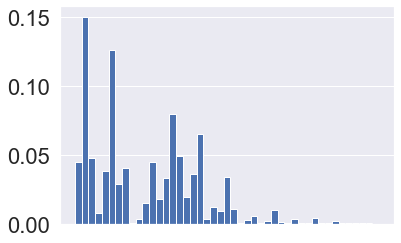

In [111]:
pd.Series(flat_list_of_selected_groups).hist(density = True, bins='auto')
# plt.hist(flat_list_of_selected_groups)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
plt.show()

In [92]:
pd.Series(flat_list_of_selected_groups).value_counts(normalize = False).round(2).nlargest(10)

headache disorders                           2399
nose ear and throat/oral cavity disorders    2014
breathing/respiratory abnormalities          1275
pain disorders                               1038
mood alterations                              791
abdominal discomfort                          760
skin/nails/hair alteration-discoloration      714
nausea/vomiting                               646
weakness/fatigue/malaise disorders            609
bowel movement/stool alterations              576
dtype: int64

In [93]:
pd.Series(flat_list_of_selected_groups).value_counts(normalize = False).nsmallest(10)

lifestyle alterations              1
upper/lower limb disorders         1
neurological disorders             5
genital abnormalities              7
cardiac abnormalities              8
chronic condition consultation     8
diabetes                           8
animal/insect bite                10
lower/upper limb disorders        11
foreign body                      11
dtype: int64

### Symptom groups confusion matrix

In [112]:
#total number of symptom categories
len(groups_to_symptoms)

53

In [1173]:
%%time
filtered_abandones_searches['predicted_symptom_groups']  = filtered_abandones_searches.progress_apply(lambda x: convert_symptoms_to_symptom_groups(list(x.mixed_score.keys())),  axis=1)

  0%|          | 0/15005 [00:00<?, ?it/s]

Wall time: 20.1 s


#### get_symptom_groups_cm
Creates the dataframe for symptom categories confusion matrix

In [1175]:
def get_symptom_groups_cm(limit_groups = len(groups_to_symptoms), rank_limit = 5):
    top_groups = list(groups_to_symptoms.keys())[:limit_groups]
        
    cm_groups = {}

    for current_group in tqdm(top_groups):
        running_dict = cm_groups.get(current_group, {})
        
        # print (current_group)
    
        for index, row in filtered_abandones_searches[filtered_abandones_searches.selected_symptom_group.apply(lambda x: current_group in x)].iterrows():
            # current_group_rank = get_index(row.predicted_symptom_groups, current_group) 

            for running_group in top_groups:
                running_score = running_dict.get(running_group, 0)
                if (get_index(row.predicted_symptom_groups, running_group) < rank_limit):
                    running_score = running_score + 1
                running_dict[running_group] = running_score
        total_searches = filtered_abandones_searches.selected_symptom_group.apply(lambda x: current_group in x).sum()
        
        for i in running_dict:
            running_dict[i] = running_dict[i] / total_searches
        
        cm_groups[current_group] = running_dict
    # print(cm_groups)    
    sr = [pd.Series(cm_groups.get(key), name = key) for key in cm_groups.keys()]
    df_ = pd.concat([pd.DataFrame([s]).T for s in sr], axis=1)
    
    return df_
    

#### Symptom categories confusion matrix (DataFrame)

In [ ]:
%%time
symptom_group_cm = get_symptom_groups_cm()
symptom_group_cm.sort_index(inplace = True)
symptom_group_cm.sort_index(axis=1, inplace = True)

In [98]:
symptom_group_cm.round(2)

abdominal discomfort  \
abdominal discomfort                                       0.78   
allergy disorders                                          0.01   
animal/insect bite                                         0.00   
back/spinal pain disorders                                 0.10   
bowel movement/stool alterations                           0.66   
breast disorders                                           0.03   
breathing/respiratory abnormalities                        0.18   
cardiac abnormalities                                      0.01   
chest pain/discomfort                                      0.03   
chronic condition consultation                             0.31   
circulatory/vascular disorders                             0.01   
cognitive/conciseness alterations                          0.02   
diabetes                                                   0.00   
dizziness                                                  0.01   
eating/weight disorders                                    0.02   
eye-vision abnormalities                                   0.09   
fertility disorders                                        0.00   
foreign body                                               0.01   
genital abnormalities                                      0.01   
genital disorders                                          0.05   
headache disorders                                         0.10   
hernias                                                    0.01   
hormonal abnormalities                                     0.00   
infectious diseases                                        0.00   
joints abnormalities                                       0.10   
lifestyle alterations                                      0.03   
lower limb disorders                                       0.11   
lower/upper limb disorders                                 0.00   
menstrual disorders                                        0.22   
mood alterations                                           0.00   
motor-muscle abnormalities                                 0.04   
nausea/vomiting                                            0.42   
neurological disorders                                     0.00   
nose ear and throat/oral cavity disorders                  0.23   
pain disorders                                             0.19   
palpable masses                                            0.16   
pedictric complaints                                       0.01   
pelvis disorders                                           0.07   
pregnancy disorders                                        0.04   
psychiatric disorders                                      0.00   
rectal disorders                                           0.05   
seizure disorders                                          0.00   
sensory abnormalities                                      0.04   
skin/nails/hair alteration-discoloration                   0.31   
speech impediments                                         0.00   
substance/medication abuse                                 0.03   
sweating disorders                                         0.01   
trauma/injury                                              0.10   
upper limb disorders                                       0.06   
upper/lower limb disorders                                 0.01   
urinary system disorders                                   0.25   
vital signs abnormalities                                  0.05   
weakness/fatigue/malaise disorders                         0.02   

                                           allergy disorders  \
abdominal discomfort                                    0.13   
allergy disorders                                       0.73   
animal/insect bite                                      0.01   
back/spinal pain disorders                              0.02   
bowel movement/stool alterations                        0.29   
breast disorders                        

In [1182]:
sum(symptom_group_cm['fertility disorders'])

5.000000000000001

In [99]:
# all selected symptom groups
len(set([val for sublist in filtered_abandones_searches.selected_symptom_group.to_list() for val in sublist]))

48

#### Symptom categories confusion matrix (plot)
Each cell represents the normalized number of hits in top-5 ranked predictions of the horizontal symptom category for the searches when the vertical category was selected as true symptom category. <br>
The diagonal represents the accuracy of our predictions of a specific symptom category for top-5 ranking.

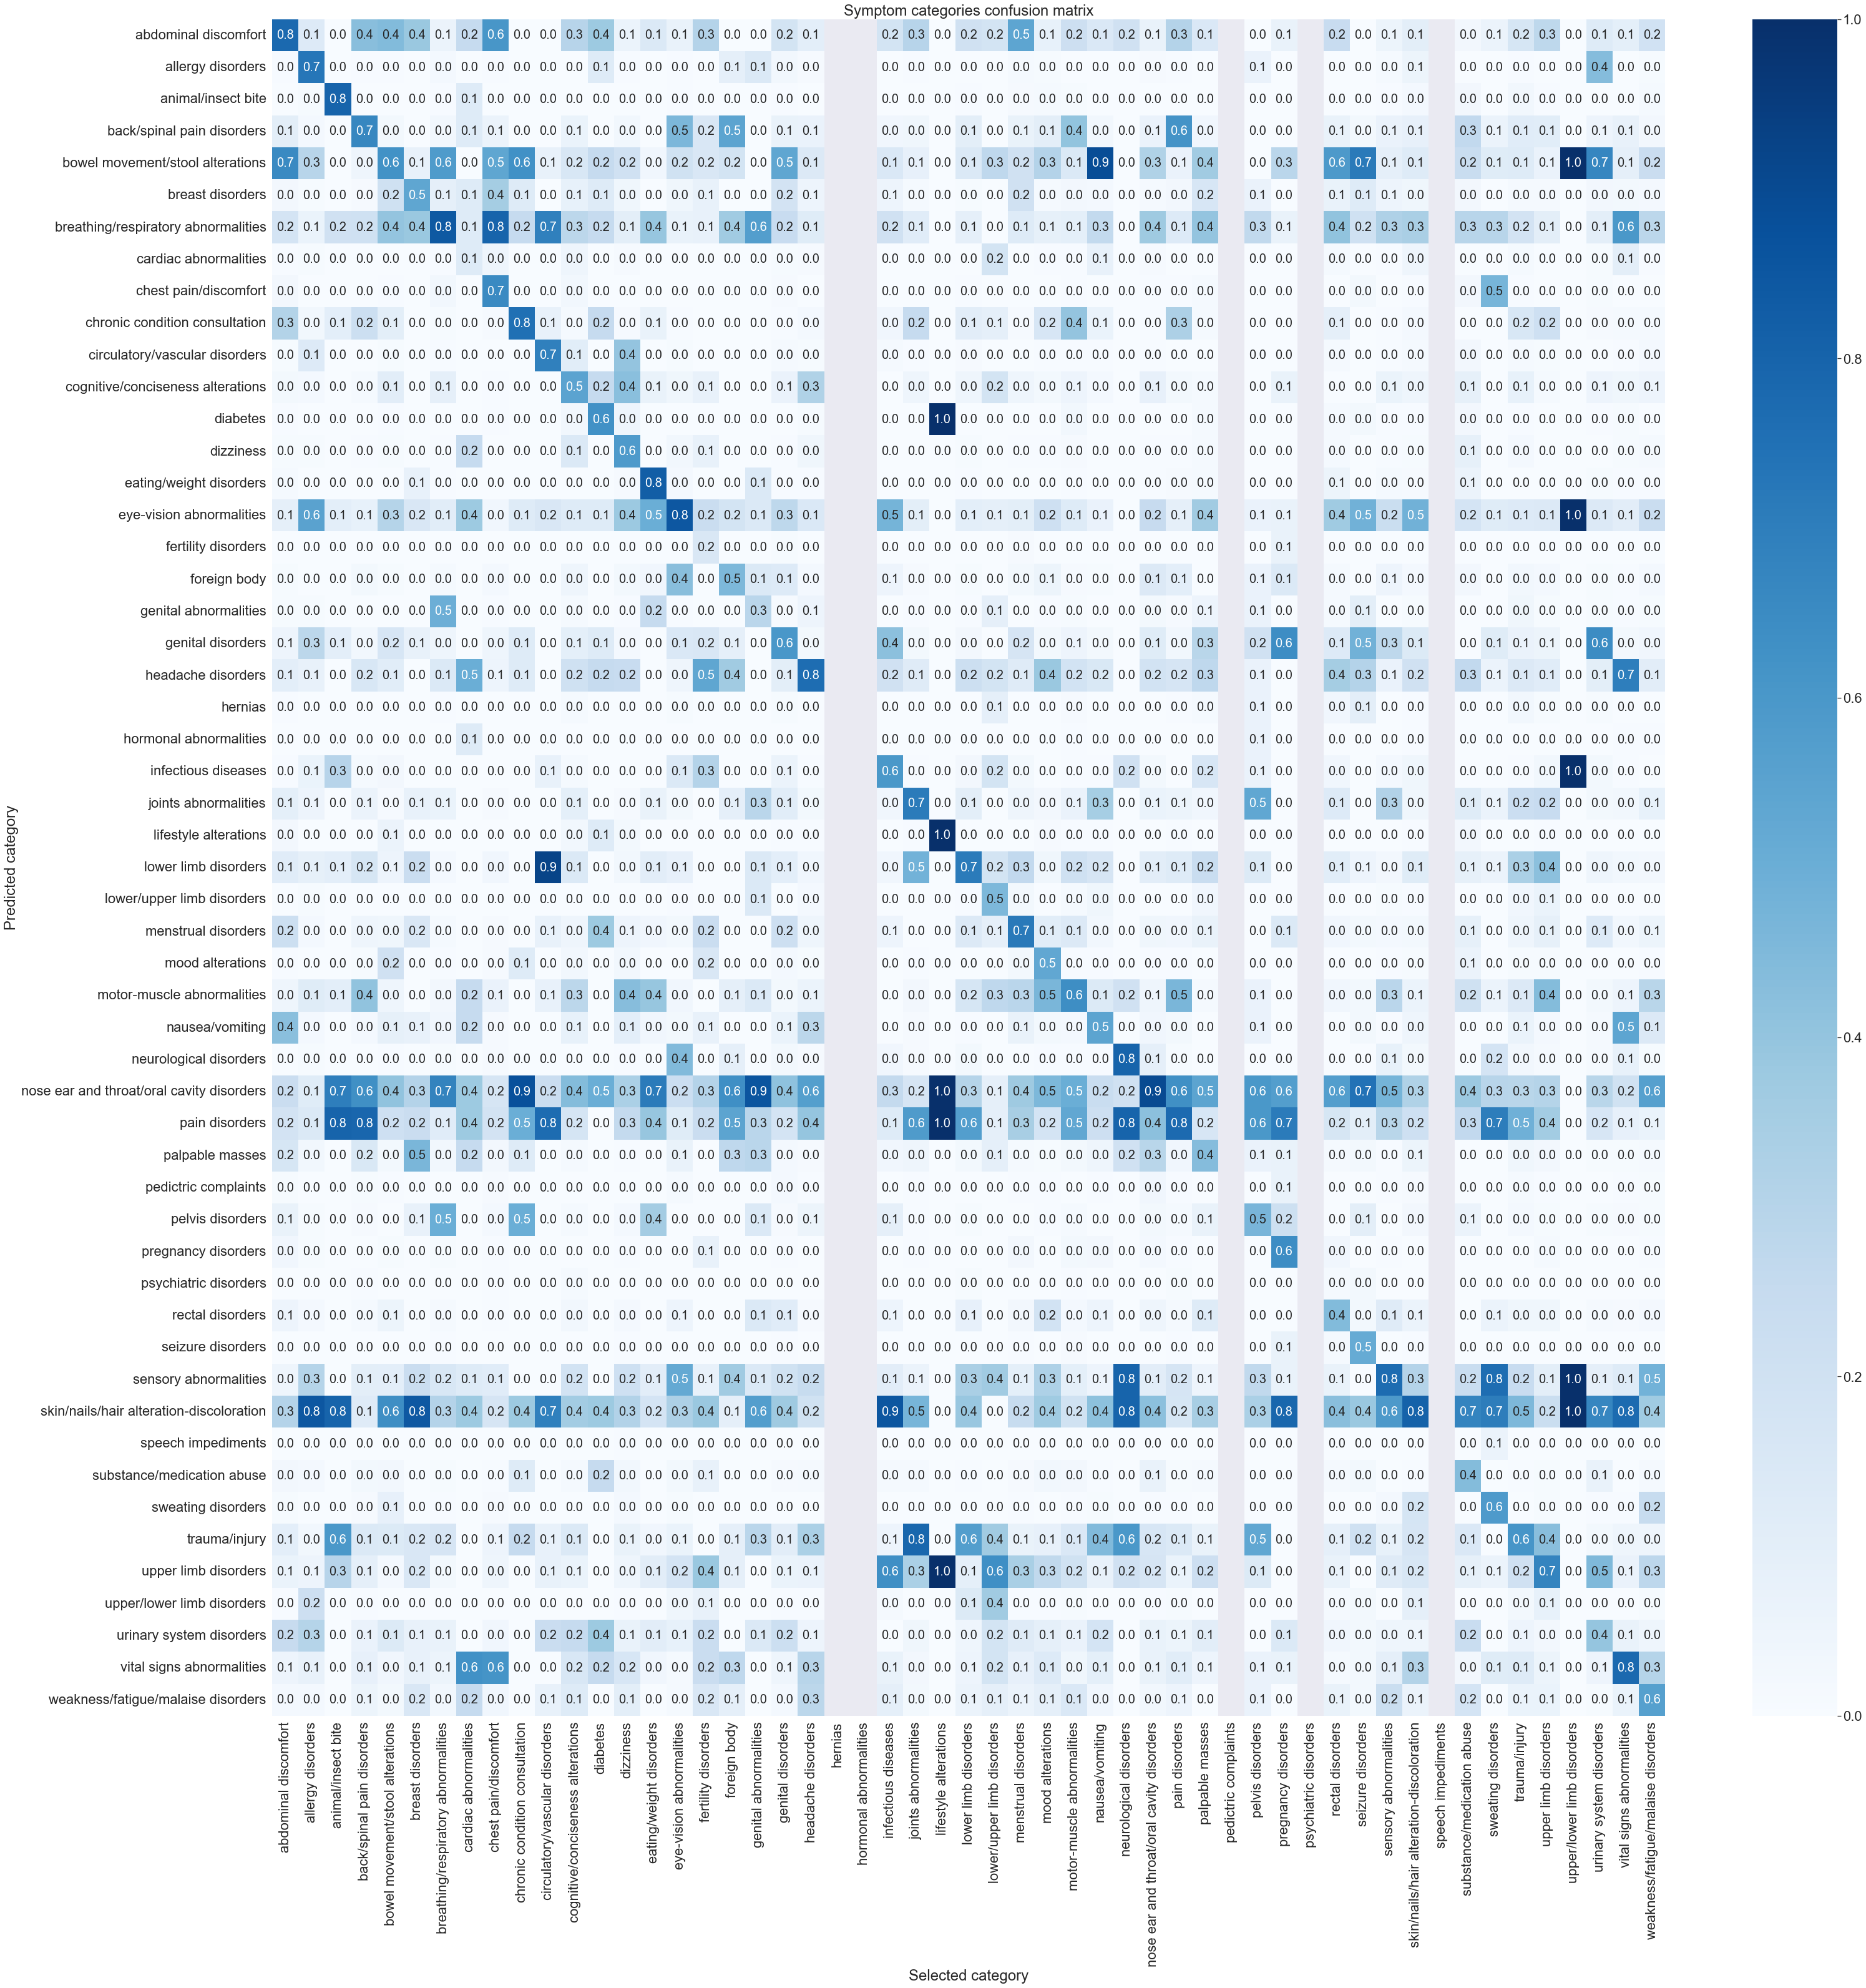

Wall time: 8.8 s


In [100]:
%%time
plt.figure(figsize=(50, 50))
sns.set(font_scale=2.0)
# symptoms_cm.style.background_gradient(cmap='Blues')
sns.heatmap(symptom_group_cm, cmap="Blues", fmt=".1f", annot_kws={"fontsize":20}, annot=True, square=False)
plt.title("Symptom categories confusion matrix")
plt.xlabel("Selected category")
plt.ylabel("Predicted category")
# plt.savefig('symptoms_cm.tiff',bbox_inches="tight", dpi = 300)
plt.show()